## This notebook documents the training process of the recommender system and Sparse Autoencoder on the Last.FM dataset, along with a comprehensive overview of the resulting performance and interpretability analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
import pickle
from sklearn.model_selection import train_test_split
import random
from scipy.special import softmax
import math
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.special import expit  # Sigmoid function
import scipy
import warnings
from typing import Callable, Any
from scipy.sparse import csr_matrix
from abc import ABC
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import plot
import heapq
import itertools


test_flag = 1

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

export_dir = os.getcwd()


# Data Filtering and Preparation

In [3]:
music_path = export_dir + "/dataset/lastFM/music_data.csv"
user_path = export_dir + "/dataset/lastFM/user_data.csv"

In [4]:
df_music = pd.read_csv(music_path)
df_user = pd.read_csv(user_path)
print(f'Number of user vectors: {len(df_user)}, Number of songs: {len(df_music)}')

Number of user vectors: 9711301, Number of songs: 50683


In [6]:
# Filter out redundant columns
columns_to_keep = ['track_id', 'name', 'artist', 'tags', 'year']
df_music_filtered = df_music[columns_to_keep]
df_music_filtered

,track_id,name,artist,tags,year
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,"rock, alternative, indie, alternative_rock, in...",2004
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,"rock, alternative, indie, pop, alternative_roc...",2006
2,TROUVHL128F426C441,Come as You Are,Nirvana,"rock, alternative, alternative_rock, 90s, grunge",1991
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,"rock, alternative, indie, alternative_rock, in...",2004
4,TRLNZBD128F935E4D8,Creep,Radiohead,"rock, alternative, indie, alternative_rock, in...",2008
...,...,...,...,...,...
50678,TRQYCFV128F9322F50,Ryusei Rocket,アンティック-珈琲店-,NaN,2008
50679,TRHQCSH128F42724B7,Colors Of The Wind,ACIDMAN,"rock, alternative_rock, japanese, cover",2004
50680,TRZRODK128F92D68D7,The Revelation,coldrain,"metal, metalcore, post_hardcore",2014
50681,TRGLMEM128F9322F63,Koi no Dependence,アンティック-珈琲店-,NaN,2008


In [7]:
# Merge the two DFs based on track_id
df_joined_user_music = pd.merge(df_user, df_music_filtered, on='track_id', how='inner')
df_joined_user_music

,track_id,user_id,playcount,name,artist,tags,year
0,TRIRLYL128F42539D1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,Nothing From Nothing,Billy Preston,"soul, funk, piano, 70s, oldies",2010
1,TRFUPBA128F934F7E1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,Paper Gangsta,Lady Gaga,"electronic, pop, female_vocalists, dance, pian...",2012
2,TRLQPQJ128F42AA94F,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,Soy,Gipsy Kings,guitar,2003
3,TRTUCUY128F92E1D24,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,Stacked Actors,Foo Fighters,"rock, alternative, alternative_rock, hard_rock...",1999
4,TRHDDQG12903CB53EE,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,Heaven's Gonna Burn Your Eyes,Thievery Corporation,"electronic, female_vocalists, ambient, chillou...",2002
...,...,...,...,...,...,...,...
9711296,TRBKFKL128E078ED76,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,1,Hailie's Song,Eminem,"pop, rap, hip_hop, love, 00s",2002
9711297,TRYFXPG128E078ECBD,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,1,Forgot About Dre,Dr. Dre,"rap, hip_hop",1999
9711298,TROBUUZ128F4263002,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,1,Paralyzer,Finger Eleven,"rock, alternative, alternative_rock, hard_rock",2007
9711299,TROEWXC128F148C83E,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,1,What's The Difference,Dr. Dre,"rap, 90s, hip_hop",1999


In [8]:
distinct_user_count = df_joined_user_music['user_id'].nunique()
distinct_track_count = df_joined_user_music['track_id'].nunique()
print(f"Number of distinct user IDs: {distinct_user_count}, Number of distinct track IDs: {distinct_track_count}")

Number of distinct user IDs: 962037, Number of distinct track IDs: 30459


In [9]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# (Optional) Widen the column-width so values don’t get wrapped
pd.set_option('display.max_colwidth', None)

## Data Filtering- to more effectively capture authentic user preferences, item attributes and underlying patterns.

Filter out users than listened to less than 50 songs

In [ ]:
# Get all values that occur more than 50×
counts = df_joined_user_music['user_id'].value_counts()
common_vals = counts[counts > 50].index

# Keep only rows whose value is in that list
df_filtered = df_joined_user_music[df_joined_user_music['user_id'].isin(common_vals)]

df_filtered

Filter out songs than were listened by less than 100 users

In [ ]:
# Get all values that occur more than 100×
counts = df_filtered['track_id'].value_counts()
common_vals = counts[counts > 100].index

# Keep only rows whose value is in that list
df_filtered_2 = df_filtered[df_filtered['track_id'].isin(common_vals)]
df_filtered_2

Another filter out of users

In [43]:
# Get all values that occur more than 50×
counts1 = df_filtered_2['user_id'].value_counts()
common_vals1 = counts1[counts1 > 50].index

# Keep only rows whose value is in that list
df_filtered1 = df_filtered_2[df_filtered_2['user_id'].isin(common_vals1)]

df_joined_user_music_new = df_filtered1.copy()
df_joined_user_music_new

,track_id,user_id,playcount,name,artist,tags,year
122,TRMKFPN128F42858C3,5a905f000fc1ff3df7ca807d57edb608863db05d,2,Caterpillar House,Black Moth Super Rainbow,"psychedelic, psychedelic_rock",2006
123,TRTSSUT128F1472A51,5a905f000fc1ff3df7ca807d57edb608863db05d,1,Tchaparian,Hot Chip,"electronic, dance",2006
124,TRNJLKP128F427CE28,5a905f000fc1ff3df7ca807d57edb608863db05d,1,Aerodynamic,Daft Punk,"electronic, dance, house, techno, electro, french",2001
125,TRGAOLV128E0789D40,5a905f000fc1ff3df7ca807d57edb608863db05d,2,Swallowed in the Sea,Coldplay,"rock, alternative, indie, pop, alternative_roc...",2005
126,TREAQSX128E07818CA,5a905f000fc1ff3df7ca807d57edb608863db05d,2,One More Time (Romanthony's Unplugged),Daft Punk,"electronic, pop, house, electro, rnb, french",2003
...,...,...,...,...,...,...,...
9711269,TRGCHLH12903CB7352,8305c896f42308824da7d4386f4b9ee584281412,5,Party In The U.S.A.,The Barden Bellas,"soundtrack, cover",2012
9711270,TRVSJOM12903CD2DC1,8305c896f42308824da7d4386f4b9ee584281412,1,One Less Lonely Girl,Justin Bieber,"pop, rnb, love",2010
9711271,TRAALAH128E078234A,8305c896f42308824da7d4386f4b9ee584281412,2,Bitter Sweet Symphony,The Verve,"rock, alternative, indie, pop, alternative_roc...",1999
9711272,TRTKLFX12903CD2DC2,8305c896f42308824da7d4386f4b9ee584281412,2,First Dance,Justin Bieber,"black_metal, industrial, thrash_metal, melodic...",2010


In [44]:
distinct_user_count = df_joined_user_music_new['user_id'].nunique()
distinct_track_count = df_joined_user_music_new['track_id'].nunique()
print(f"Number of distinct user IDs: {distinct_user_count}, Number of distinct track IDs: {distinct_track_count}")

Number of distinct user IDs: 11666, Number of distinct track IDs: 4318


In [514]:
df_joined_user_music_new.to_csv(export_dir+'/dataset/lastFM/df_joined_user_music.csv')

In [8]:
df_joined_user_music_new= pd.read_csv(export_dir+'/dataset/lastFM//df_joined_user_music_new.csv')
df_joined_user_music_new= df_joined_user_music_new.drop(columns = 'Unnamed: 0')

df_joined_user_music_new

,track_id,user_id,playcount,name,artist,tags,year
0,TRMKFPN128F42858C3,5a905f000fc1ff3df7ca807d57edb608863db05d,2,Caterpillar House,Black Moth Super Rainbow,"psychedelic, psychedelic_rock",2006
1,TRTSSUT128F1472A51,5a905f000fc1ff3df7ca807d57edb608863db05d,1,Tchaparian,Hot Chip,"electronic, dance",2006
2,TRNJLKP128F427CE28,5a905f000fc1ff3df7ca807d57edb608863db05d,1,Aerodynamic,Daft Punk,"electronic, dance, house, techno, electro, french",2001
3,TRGAOLV128E0789D40,5a905f000fc1ff3df7ca807d57edb608863db05d,2,Swallowed in the Sea,Coldplay,"rock, alternative, indie, pop, alternative_roc...",2005
4,TREAQSX128E07818CA,5a905f000fc1ff3df7ca807d57edb608863db05d,2,One More Time (Romanthony's Unplugged),Daft Punk,"electronic, pop, house, electro, rnb, french",2003
...,...,...,...,...,...,...,...
862283,TRGCHLH12903CB7352,8305c896f42308824da7d4386f4b9ee584281412,5,Party In The U.S.A.,The Barden Bellas,"soundtrack, cover",2012
862284,TRVSJOM12903CD2DC1,8305c896f42308824da7d4386f4b9ee584281412,1,One Less Lonely Girl,Justin Bieber,"pop, rnb, love",2010
862285,TRAALAH128E078234A,8305c896f42308824da7d4386f4b9ee584281412,2,Bitter Sweet Symphony,The Verve,"rock, alternative, indie, pop, alternative_roc...",1999
862286,TRTKLFX12903CD2DC2,8305c896f42308824da7d4386f4b9ee584281412,2,First Dance,Justin Bieber,"black_metal, industrial, thrash_metal, melodic...",2010


## Create 'user_song_matrix'


In [ ]:
# Create the user-song matrix
user_song_matrix = df_joined_user_music_new.groupby(['user_id', 'track_id']).size().unstack(fill_value=0)
users_index = user_song_matrix.index

# Convert the matrix to binary (1 if listened, 0 otherwise)
user_song_matrix = (user_song_matrix > 0).astype(int)
user_song_matrix = user_song_matrix.reset_index(drop=True)
user_song_matrix

track_id,TRAABJS128F9325C99,TRAACPH12903CF5F14,TRAAFGQ128F427D884,TRAAFOY128F146CC17,TRAAGCZ128F93210FD,TRAAJJW128F4298683,TRAAKDG128F42A0ECB,TRAALAH128E078234A,TRAANSZ128F425DD63,TRAASQC128F93480F0,...,TRZYAGJ128F9332CEF,TRZYESA128F148D67F,TRZYWCD128F425C7FD,TRZYYJH128E0791268,TRZZEVQ128F92CFD63,TRZZKOL128F93112EF,TRZZUBQ128F9351D51,TRZZUTD12903CADD68,TRZZYMU128E0792400,TRZZZRJ128F42819AF
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11661,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
11662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11663,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11664,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
user_song_matrix.to_csv(export_dir+'/dataset/lastFM/user_song_matrix.csv')

load user_song_matrix

In [11]:
user_song_matrix = pd.read_csv(export_dir+'/dataset/lastFM/user_song_matrix.csv')
user_song_matrix= user_song_matrix.drop(columns = 'Unnamed: 0')

user_song_matrix

,TRAABJS128F9325C99,TRAACPH12903CF5F14,TRAAFGQ128F427D884,TRAAFOY128F146CC17,TRAAGCZ128F93210FD,TRAAJJW128F4298683,TRAAKDG128F42A0ECB,TRAALAH128E078234A,TRAANSZ128F425DD63,TRAASQC128F93480F0,...,TRZYAGJ128F9332CEF,TRZYESA128F148D67F,TRZYWCD128F425C7FD,TRZYYJH128E0791268,TRZZEVQ128F92CFD63,TRZZKOL128F93112EF,TRZZUBQ128F9351D51,TRZZUTD12903CADD68,TRZZYMU128E0792400,TRZZZRJ128F42819AF
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11661,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
11662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11663,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11664,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#Editing items_data

In [9]:
items_data = df_joined_user_music_new[['track_id','name','artist','tags','year']].drop_duplicates(subset='track_id').reset_index(drop=True)
items_data

,track_id,name,artist,tags,year
0,TRMKFPN128F42858C3,Caterpillar House,Black Moth Super Rainbow,"psychedelic, psychedelic_rock",2006
1,TRTSSUT128F1472A51,Tchaparian,Hot Chip,"electronic, dance",2006
2,TRNJLKP128F427CE28,Aerodynamic,Daft Punk,"electronic, dance, house, techno, electro, french",2001
3,TRGAOLV128E0789D40,Swallowed in the Sea,Coldplay,"rock, alternative, indie, pop, alternative_roc...",2005
4,TREAQSX128E07818CA,One More Time (Romanthony's Unplugged),Daft Punk,"electronic, pop, house, electro, rnb, french",2003
...,...,...,...,...,...
4313,TRQRHUG128F14A8949,Settlin',Sugarland,country,2006
4314,TREYLBG128F934B6EA,Under The Northern Star,Amon Amarth,"metal, death_metal, melodic_death_metal",2006
4315,TRXLBFN128EF343BFE,Spring nicht,Tokio Hotel,"rock, german",2010
4316,TRGEUIY128F4268A5F,I've Seen That Face Before (Libertango),Grace Jones,"electronic, pop, female_vocalists, 80s, chillo...",2014


In [49]:
# items_data.to_csv(export_dir+'/dataset/lastFM/items_data.csv')

In [13]:
items_data.index = items_data['track_id']
items_data = items_data.loc[user_song_matrix.columns]
items_data.index = range(items_data.shape[0])
items_data

,track_id,name,artist,tags,year
0,TRAABJS128F9325C99,Auburn and Ivory,Beach House,"indie, downtempo",2006
1,TRAACPH12903CF5F14,Double Feature,Camera Obscura,"indie, female_vocalists, post_rock, post_punk,...",2001
2,TRAAFGQ128F427D884,One Last Time,The Kooks,"rock, alternative, indie, indie_rock, british,...",2008
3,TRAAFOY128F146CC17,Astair,Matt Costa,"folk, singer_songwriter, chillout, acoustic, m...",2014
4,TRAAGCZ128F93210FD,Let's Get It Started,Black Eyed Peas,"pop, dance, rap, hip_hop, funk, american, rnb,...",2013
...,...,...,...,...,...
4313,TRZZKOL128F93112EF,No More Runnin,Animal Collective,"electronic, indie, experimental, indie_rock, c...",2009
4314,TRZZUBQ128F9351D51,Take What You Take,Lily Allen,"indie, pop, female_vocalists, singer_songwrite...",2009
4315,TRZZUTD12903CADD68,Solo Dolo (Nightmare),Kid Cudi,"alternative, rap, hip_hop, american",2009
4316,TRZZYMU128E0792400,Flutter Girl,Chris Cornell,"rock, alternative, grunge",1999


In [14]:
items_data_new = items_data.copy()
items_data_new

,track_id,name,artist,tags,year
0,TRAABJS128F9325C99,Auburn and Ivory,Beach House,"indie, downtempo",2006
1,TRAACPH12903CF5F14,Double Feature,Camera Obscura,"indie, female_vocalists, post_rock, post_punk,...",2001
2,TRAAFGQ128F427D884,One Last Time,The Kooks,"rock, alternative, indie, indie_rock, british,...",2008
3,TRAAFOY128F146CC17,Astair,Matt Costa,"folk, singer_songwriter, chillout, acoustic, m...",2014
4,TRAAGCZ128F93210FD,Let's Get It Started,Black Eyed Peas,"pop, dance, rap, hip_hop, funk, american, rnb,...",2013
...,...,...,...,...,...
4313,TRZZKOL128F93112EF,No More Runnin,Animal Collective,"electronic, indie, experimental, indie_rock, c...",2009
4314,TRZZUBQ128F9351D51,Take What You Take,Lily Allen,"indie, pop, female_vocalists, singer_songwrite...",2009
4315,TRZZUTD12903CADD68,Solo Dolo (Nightmare),Kid Cudi,"alternative, rap, hip_hop, american",2009
4316,TRZZYMU128E0792400,Flutter Girl,Chris Cornell,"rock, alternative, grunge",1999


## Find unique tags

In [15]:
all_tags = []
for row in items_data.index:

  if pd.notna(items_data.loc[row, 'tags']):
    genre_list = items_data.loc[row, 'tags'].split(', ')[:2]
    all_tags.extend(genre_list)

unique_tags = list(set(all_tags))
unique_tags

['rock',
 'british',
 'progressive_metal',
 'trip_hop',
 'female_vocalists',
 'japanese',
 'indie_rock',
 'downtempo',
 'emo',
 'power_metal',
 'punk',
 'house',
 'heavy_metal',
 '60s',
 'metalcore',
 'thrash_metal',
 'grunge',
 'russian',
 'psychedelic',
 'screamo',
 'death_metal',
 'blues',
 '90s',
 'german',
 'gothic',
 'alternative_rock',
 'folk',
 'melodic_death_metal',
 'instrumental',
 'avant_garde',
 '00s',
 'techno',
 'nu_metal',
 'black_metal',
 'new_age',
 'drum_and_bass',
 'idm',
 'rnb',
 'chillout',
 'punk_rock',
 'country',
 'reggae',
 'rap',
 'ska',
 'experimental',
 'american',
 'indie_pop',
 'dark_ambient',
 'symphonic_metal',
 'singer_songwriter',
 '70s',
 'post_punk',
 '80s',
 'guitar',
 'swedish',
 'polish',
 'post_hardcore',
 'britpop',
 'classic_rock',
 'hardcore',
 'blues_rock',
 'post_rock',
 'cover',
 'funk',
 'trance',
 'male_vocalists',
 'alternative',
 'gothic_metal',
 'hard_rock',
 'doom_metal',
 'piano',
 'hip_hop',
 'mellow',
 'oldies',
 'jazz',
 'lounge'

#  Create df_songs_data_

In [16]:
df_songs_data_ = pd.DataFrame(0, index=items_data_new.index, columns=unique_tags)
movie_data = []

for i in items_data_new.index:

    movie_dict = {genre: 0 for genre in unique_tags}
    movie_dict['movie_id'] = int(i)

    if pd.notna(items_data.loc[i,'tags']):
      # Split the genres and set the corresponding genre keys to 1
      genre_list = items_data.loc[i,'tags'].split(', ')
      df_songs_data_.loc[i, genre_list] = 1

df_songs_data_.sum()

,0
rock,1248
british,379
progressive_metal,63
trip_hop,258
female_vocalists,529
...,...
ambient,342
grindcore,7
industrial,71
classical,24


In [17]:
df_songs_data_

,rock,british,progressive_metal,trip_hop,female_vocalists,japanese,indie_rock,downtempo,emo,power_metal,...,soundtrack,dance,synthpop,psychedelic_rock,indie,ambient,grindcore,industrial,classical,noise
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4313,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4314,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4315,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4316,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
#distribution of the current dataser- 4318 songs, into genres
with pd.option_context('display.max_rows', None):
    print(df_songs_data_.sum())

rock                   1248
british                 379
progressive_metal        63
trip_hop                258
female_vocalists        529
japanese                  5
indie_rock              878
downtempo               283
emo                     223
power_metal              46
punk                    317
house                    71
heavy_metal             145
60s                      52
metalcore                85
thrash_metal             68
grunge                  166
russian                   2
psychedelic             221
screamo                  87
death_metal              67
blues                   143
90s                     329
german                   45
gothic                   35
alternative_rock        688
folk                    592
melodic_death_metal      69
instrumental            287
avant_garde              38
00s                     452
techno                   89
nu_metal                 48
black_metal              12
new_age                  42
drum_and_bass       

In [19]:
df_songs_data = df_songs_data_.copy()

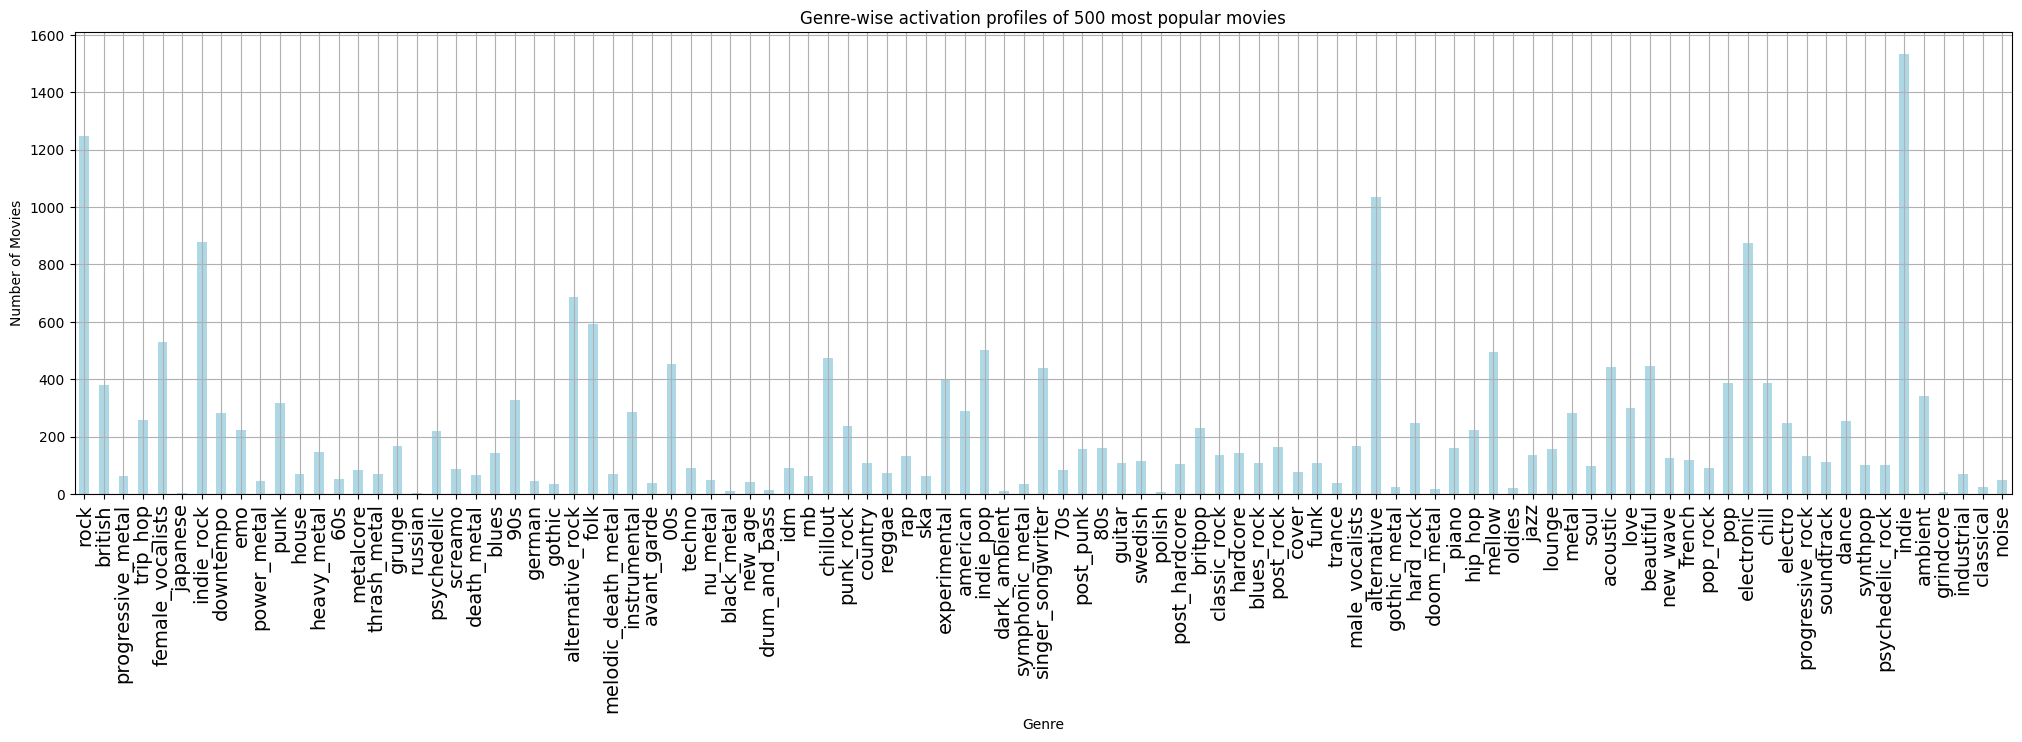

,0
rock,1248
british,379
progressive_metal,63
trip_hop,258
female_vocalists,529
...,...
ambient,342
grindcore,7
industrial,71
classical,24


In [519]:
num_per_genre = df_songs_data.sum(axis=0)

plt.figure(figsize=(25,6))
num_per_genre.plot(kind='bar', color='lightblue')
plt.title('Genre-wise activation profiles of 500 most popular movies')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90,fontsize=14)
plt.grid(True)
plt.show()

num_per_genre

--



--

--

--

--

# Recommender system: matrix factorization

## Data preparation

In [20]:
pos_ex = {(row): user_song_matrix.columns[user_song_matrix.iloc[row] == 1].tolist() for row in user_song_matrix.index}
neg_ex = {(row): user_song_matrix.columns[user_song_matrix.iloc[row] == 0].tolist() for row in user_song_matrix.index}
pos_ex_num = {(row): len(pos_ex[row]) for row in user_song_matrix.index}

In [21]:
popularity= user_song_matrix.sum(axis=0)
dist_pop = [(occur)/(np.array(popularity)).sum() for occur in popularity] # same dist for all users

In [72]:
dist_pop_neg_per_user = {}
for row in user_song_matrix.index:
  curr_dist_neg = []
  for i in range(user_song_matrix.shape[1]):
    if user_song_matrix.columns[i] in neg_ex[row]:
      curr_dist_neg.append(dist_pop[i])
  dist_pop_neg_per_user[row]=curr_dist_neg

with open(Path(export_dir,'dataset/lastFM/dist_pop_neg_per_user.pkl'), 'wb') as file:
    pickle.dump(dist_pop_neg_per_user, file)

In [77]:
dist_pop_pos_per_user = {}
for row in user_song_matrix.index:
  curr_dist_pos = []
  for i in range(user_song_matrix.shape[1]):
    if user_song_matrix.columns[i] in pos_ex[row]:
      curr_dist_pos.append(dist_pop[i])
  dist_pop_pos_per_user[row]=curr_dist_pos

with open(Path(export_dir,'dataset/lastFM/dist_pop_pos_per_user.pkl'), 'wb') as file:
    pickle.dump(dist_pop_pos_per_user, file)

In [ ]:
# with open(Path(export_dir,'dataset/lastFM/dist_pop_neg_per_user.pkl'), 'rb') as file:
#     dist_pop_neg_per_user = pickle.load(file)

In [ ]:
# with open(Path(export_dir,'dataset/lastFM/dist_pop_pos_per_user.pkl'), 'rb') as file:
#     dist_pop_pos_per_user = pickle.load(file)

In [82]:
sum_per_user_neg_exp = {key: np.sum(np.exp(np.array(value))) for key, value in dist_pop_neg_per_user.items()}
norm_prob_neg_exp = {(row): [(np.exp(np.array(dist_pop_neg_per_user[row][i])))/sum_per_user_neg_exp[row] for i in range(len(dist_pop_neg_per_user[row]))] for row in user_song_matrix.index}

In [83]:
sum_per_user_pos_exp = {key: np.sum(np.exp(np.array(value))) for key, value in
                           dist_pop_pos_per_user.items()}
norm_prob_pos_exp = {(row): [(np.exp(np.array(dist_pop_pos_per_user[row][i])))
                            /sum_per_user_pos_exp[row] for i in
                             range(len(dist_pop_pos_per_user[row]))] for
                            row in user_song_matrix.index}

In [84]:
pos_idx_ex_hidden = {(row): np.sort(np.random.choice(pos_ex[row], size=5,replace=True, p=norm_prob_pos_exp[row])) for row in user_song_matrix.index}

pos_idx_ex_use = {(row): [item for item in pos_ex[row] if item not in pos_idx_ex_hidden[row]] for row in user_song_matrix.index}

# # if there are no neg examples in test set
# neg_ex_hidden = []

In [86]:
# sample negative examples to test set:
test_pop_neg = {(row): list(np.random.choice(neg_ex[row],
                       size=5,replace=False, p=norm_prob_neg_exp[row]))
                       for row in user_song_matrix.index}
test_unif_neg = {(row): random.sample(neg_ex[row],5) for row in
                        user_song_matrix.index}

# take test set examples out of all neg examles bank- neg_ex
# wrt popularity
neg_ex_use_pop = {(row): list(filter(lambda x: x not in test_pop_neg[row],
                                neg_ex[row])) for row in user_song_matrix.index}
# uniformly
neg_ex_use_unif = {(row): list(filter(lambda x: x not in test_unif_neg[row],
                                neg_ex[row])) for row in user_song_matrix.index}

neg_ex_hidden = test_pop_neg
neg_ex_use = neg_ex_use_pop

# new train set for popularity: no 10 examples
train_set_pop = {(row): (neg_ex_use[row]+ pos_idx_ex_use[row]) for row in user_song_matrix.index}

In [87]:
dist_pop_neg_use_per_user = {}
for row in user_song_matrix.index:
  curr_dist_neg_use = []
  for i in range(user_song_matrix.shape[1]):
    if user_song_matrix.columns[i] in neg_ex_use[row]:
      curr_dist_neg_use.append(dist_pop[i])
  dist_pop_neg_use_per_user[row]=curr_dist_neg_use

with open(Path(export_dir,'dataset/lastFM/dist_pop_neg_use_per_user.pkl'), 'wb') as file:
    pickle.dump(dist_pop_neg_use_per_user, file)

In [88]:
# with open(Path(export_dir,'dataset/lastFM/dist_pop_neg_use_per_user.pkl'), 'wb') as file:
#     pickle.dump(dist_pop_neg_use_per_user, file)

In [89]:
sum_per_user_neg_use_exp = {key: np.sum(np.exp(np.array(value))) for key, value
                        in dist_pop_neg_use_per_user.items()}
norm_prob_neg_use_exp = {(row): [(np.exp(np.array(dist_pop_neg_use_per_user[row][i])))
                            /sum_per_user_neg_use_exp[row] for i in
                             range(len(dist_pop_neg_use_per_user[row]))] for row in
                             user_song_matrix.index}

# 1- hot

In [90]:
# for neg examples in test set:
neg_ex_unif = {(row): random.sample(neg_ex_use_unif[row],(pos_ex_num[row]-5)) for row in user_song_matrix.index if (pos_ex_num[row]-5) < user_song_matrix.shape[1]/2}
neg_ex_popularity = {(row): list(np.random.choice(neg_ex_use_pop[row],
                      size=len(pos_ex[row]),replace=False, p=norm_prob_neg_use_exp[row]))
                      for row in user_song_matrix.index}

# change wrt unif/pop:
neg_idx_ex_use = neg_ex_popularity

df_1hot = pd.DataFrame(-1, index = user_song_matrix.index, columns = user_song_matrix.columns)
for row in range(len(neg_idx_ex_use)):

  df_1hot.loc[row,neg_idx_ex_use[row]]=0
  df_1hot.loc[row,pos_idx_ex_use[row]]=1

# Create MF class

In [367]:
USERS = len(user_song_matrix)
ITEMS = len(user_song_matrix.columns)
print(USERS,ITEMS)

11666 4318


In [23]:
def normalize_val(recommend_tuple_list):
  normalized_data = [(item[0], (item[1] - min(recommend_tuple_list, key=lambda
                      x: x[1])[1]) / (max(recommend_tuple_list, key=lambda x:
                    x[1])[1] - min(recommend_tuple_list, key=lambda x: x[1])[1])) for item in recommend_tuple_list]
  return normalized_data


class MatrixFactorization:
    def __init__(self, R, pos_idx_ex_use, neg_idx_ex_use, neg_ex_hidden, neg_ex, pos_ex_num, K, alpha, beta, iterations, pop_flag):
        self.R = R
        self.ratings = R
        self.num_users = R.shape[0]
        self.num_items = R.shape[1]
        self.K = K  # latent dimensions (e.g., 20)
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initialize biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)

        self.pos_idx_ex_use = pos_idx_ex_use
        self.neg_idx_ex_use = neg_idx_ex_use
        self.neg_ex = neg_ex
        self.neg_ex_hidden = neg_ex_hidden
        self.neg_ex_use = {(row): list(filter(lambda x: x not in self.neg_ex_hidden[row],
                                self.neg_ex[row])) for row in self.R.index}
        self.pos_ex_num = pos_ex_num
        self.pop_flag = pop_flag

        self.columns = list(self.ratings.columns)
        # To store batch logs across epochs if needed.
        self.batch_history = []

    def sgd_batch(self, batch_samples):
        # Convert mini-batch samples to arrays
        users = np.array([s[0] for s in batch_samples], dtype=int)
        items = np.array([s[1] for s in batch_samples], dtype=int)
        ratings = np.array([s[2] for s in batch_samples], dtype=float)

        # Compute predictions vectorized
        predictions = expit(self.b_u[users] + self.b_i[items] + np.sum(self.P[users] * self.Q[items], axis=1))
        errors = ratings - predictions  # error vector

        # Compute gradients for biases and latent factors
        grad_b_u = self.alpha * (errors - self.beta * self.b_u[users])
        grad_b_i = self.alpha * (errors - self.beta * self.b_i[items])
        grad_P = self.alpha * (errors[:, np.newaxis] * self.Q[items] - self.beta * self.P[users])
        grad_Q = self.alpha * (errors[:, np.newaxis] * self.P[users] - self.beta * self.Q[items])

        # Use of np.add.at to accumulate updates correctly for duplicate indices
        np.add.at(self.b_u, users, grad_b_u)
        np.add.at(self.b_i, items, grad_b_i)
        np.add.at(self.P, users, grad_P)
        np.add.at(self.Q, items, grad_Q)


    def rmse(self):
        # Compute full prediction matrix
        predicted = expit(self.b_u[:, np.newaxis] + self.b_i[np.newaxis, :] + self.P.dot(self.Q.T))
        error = 0
        count = 0
        # Only consider positive examples (rating==1)
        for i, k, r, _ in self.samples:
            if r == 1:
                error += (1 - predicted[i, k]) ** 2
                count += 1
        return np.sqrt(error / count) if count > 0 else None

    def get_rating(self, i, j):
        return expit(self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T))


    def full_matrix(self):
        return expit(self.b_u[:, np.newaxis] + self.b_i[np.newaxis, :] + self.P.dot(self.Q.T))

    def recommend(self, user_id, top_n):
        df_user_ratings = pd.DataFrame(self.full_matrix(), index=self.R.index, columns=self.R.columns)
        df_user_ratings_one = df_user_ratings.loc[user_id]
        recommendations = [(i, df_user_ratings_one.loc[i]) for i in df_user_ratings.columns]
        recommendations.sort(key=lambda x: x[1], reverse=True)
        return recommendations[:top_n]

    def recommend_norm(self, user_id, top_n):
        return normalize_val(self.recommend(user_id, top_n))



In [24]:
def train(self, batch_size=256, save_batches=False, batches_save_path=True):
        """
        Trains the model using mini-batch SGD.

        :param batch_size: Number of samples per mini-batch.
        :param save_batches: If True, save the examples in each batch.
        :param batches_save_path: If provided, the path to which the batch history will be saved via pickle.
        """
        self.batch_history = []  # Reset batch history
        for epoch in range(self.iterations):
            start_time = time.time()

            # Re-sample negatives and build the one-hot matrix using class dimensions
            neg_ex_unif = {
                row: random.sample(self.R.columns[self.R.iloc[row] == 0].tolist(), self.pos_ex_num[row])
                for row in self.R.index if self.pos_ex_num[row] < self.R.shape[1] / 2
            }
            neg_ex_popularity = {
                row: list(np.random.choice(self.neg_ex_use[row],
                  size=len(self.pos_idx_ex_use[row]), replace=False, p=norm_prob_neg_use_exp[row]))
                for row in self.R.index
            }
            neg_idx_ex_use = neg_ex_popularity

            # Build one-hot DataFrame with entries: 1 for positive, 0 for negatives, -1 otherwise
            self.df_1hot = pd.DataFrame(-1, index=self.R.index, columns=self.R.columns)
            for row in range(self.num_users):
                self.df_1hot.loc[row, self.neg_idx_ex_use[row]] = 0
                self.df_1hot.loc[row, self.pos_idx_ex_use[row]] = 1

            # Create list of training samples: (user index, item index, rating, item id)
            self.samples = [
                (i, j, self.df_1hot.iloc[i, j], self.df_1hot.columns[j])
                for i in range(self.num_users)
                for j in range(self.num_items)
                if self.df_1hot.iloc[i, j] != -1
            ]

            print(f"Epoch {epoch+1}; samples: {len(self.samples)}; time so far: {time.time()-start_time:.2f}s")

            # Shuffle the samples for mini-batch creation
            random.shuffle(self.samples)

            epoch_batches = []  # Save batches for this epoch if needed

            # Process samples in mini-batches
            for start in range(0, len(self.samples), batch_size):
                batch_samples = self.samples[start:start+batch_size]
                if save_batches:
                    epoch_batches.append(batch_samples)
                self.sgd_batch(batch_samples)

            # Optionally log the epoch's batches
            if save_batches:
                self.batch_history.append(epoch_batches)

            rmse_val = self.rmse()
            print(f"Epoch {epoch+1}; RMSE: {rmse_val:.4f}; epoch time: {time.time()-start_time:.2f}s")

        # Optionally, save the batch history to a file using pickle.
        if save_batches and batches_save_path is not None:
            with open(Path(export_dir,'dataset/lastFM',batches_save_path), 'wb') as f:
                pickle.dump(self.batch_history, f)
            print(f"Batch history saved to {batches_save_path}")


# Run Model

In [ ]:
mf_recommender = MatrixFactorization(user_song_matrix, pos_idx_ex_use,neg_idx_ex_use,neg_ex_hidden, neg_ex, pos_ex_num, K=20, alpha=0.05, beta=0.01, iterations=4, pop_flag = 1)

In [ ]:
train(mf_recommender, batch_size=256, save_batches=True, batches_save_path=export_dir+'dataset/lastFM/batch_history.pkl')

# Load Existing Model

In [29]:
model_name = 'mf_model_lastFM'

In [30]:
with open(Path(export_dir,f'models/lastFM/{model_name}.pkl') , 'rb') as file:
    MatrixFactorization = pickle.load(file)
pos_idx_ex_hidden = {(row): [item for item in pos_ex[row] if item not in MatrixFactorization.pos_idx_ex_use[row]] for row in MatrixFactorization.R.index}

save the model

In [109]:
with open(Path(export_dir,'models/lastFM', f'{model_name}.pkl'), 'wb') as file:
    pickle.dump(mf_recommender, file)

# Train a new recsys model

In [ ]:
df_Q= pd.DataFrame(mf_recommender.Q)#pd.DataFrame(MatrixFactorization.Q)
df_Q.index = user_song_matrix.columns

df_Q.to_csv(Path(export_dir,'dataset/lastFM/items_embeddings_mf_model_0.05_0.01_pop_Windex.csv'))
df_Q.to_csv(Path(export_dir,'dataset/lastFM/items_embeddings_mf_model_0.05_0.01_pop.csv'), index=False)


df_P=  pd.DataFrame(mf_recommender.P)#pd.DataFrame(MatrixFactorization.P)
df_P.index = user_song_matrix.index
df_P.to_csv(Path(export_dir,'dataset/lastFM/users_embeddings_mf_model_0.05_0.01_pop.csv'), index=False)
df_P.to_csv(Path(export_dir,'dataset/lastFM/users_embeddings_mf_model_0.05_0.01_pop_Windex.csv'))

df_b_i= pd.DataFrame(mf_recommender.b_i) #pd.DataFrame(MatrixFactorization.b_i)
df_b_u= pd.DataFrame(mf_recommender.b_u) #pd.DataFrame(MatrixFactorization.b_u)

df_b_i.index = user_song_matrix.columns
df_b_u.index = user_song_matrix.index

df_b_i.to_csv(Path(export_dir,'dataset/lastFM/b_i_mf_model_0.05_0.01_pop.csv'), index=False)
df_b_i.to_csv(Path(export_dir,'dataset/lastFM/b_i_mf_model_0.05_0.01_pop_Windex.csv'))

df_b_u.to_csv(Path(export_dir,'dataset/lastFM/b_u_mf_model_0.05_0.01_pop.csv'), index=False)
df_b_u.to_csv(Path(export_dir,'dataset/lastFM/b_u_mf_model_0.05_0.01_pop_Windex.csv'))

## TEST MF:

In [ ]:
mean_percentile_rank = 0
percentile_rank = 0
for user_id in range(len(pos_idx_ex_hidden)):
    hidden_items = pos_idx_ex_hidden[user_id]
    recommendations = mf_recommender.recommend(user_id, ITEMS)
    rr = 0
    for item_id in hidden_items:
        for rank, (rec_item_id, _) in enumerate(recommendations):
            if rec_item_id == item_id:
                rr += (rank/ITEMS)*100
    percentile_rank += rr/len(hidden_items)
mean_percentile_rank = percentile_rank/len(pos_idx_ex_hidden)

a1 = pd.DataFrame({'mpr':[mean_percentile_rank]})
a1


In [ ]:
hit_rate_at_k = 0
num_user_w_rel_item = 0
for user_id in range(len(pos_idx_ex_hidden)):
    hidden_items = pos_idx_ex_hidden[user_id]
    recommendations = mf_recommender.recommend(user_id, 20)
    used_flag = 0
    for item_id in hidden_items:
        for rank, (rec_item_id, _) in enumerate(recommendations):
            if rec_item_id == item_id and used_flag==0:
                used_flag = 1
                num_user_w_rel_item += 1

hit_rate_at_k = num_user_w_rel_item/len(pos_idx_ex_hidden)
a2 = pd.DataFrame({'HRatK':[hit_rate_at_k]})
a2


# SAE

## Filter data into genres

In [34]:
genres = unique_tags

In [167]:
genre_rock_id = np.array(np.where(df_songs_data[genres[0]] == 1)[0])
genre_rock_id_name = list(df_songs_data.index[genre_rock_id])

genre_british_id = np.array(np.where(df_songs_data[genres[1]] == 1)[0])
genre_british_id_name = list(df_songs_data.index[genre_british_id])

genre_progressive_metal_id = np.array(np.where(df_songs_data[genres[2]] == 1)[0])
genre_progressive_metal_id_name = list(df_songs_data.index[genre_progressive_metal_id])

genre_trip_hop_id = np.array(np.where(df_songs_data[genres[3]] == 1)[0])
genre_trip_hop_id_name = list(df_songs_data.index[genre_trip_hop_id])

genre_female_vocalists_id = np.array(np.where(df_songs_data[genres[4]] == 1)[0])
genre_female_vocalists_id_name = list(df_songs_data.index[genre_female_vocalists_id])

genre_japanese_id = np.array(np.where(df_songs_data[genres[5]] == 1)[0])
genre_japanese_id_name = list(df_songs_data.index[genre_japanese_id])

genre_indie_rock_id = np.array(np.where(df_songs_data[genres[6]] == 1)[0])
genre_indie_rock_id_name = list(df_songs_data.index[genre_indie_rock_id])

genre_downtempo_id = np.array(np.where(df_songs_data[genres[7]] == 1)[0])
genre_downtempo_id_name = list(df_songs_data.index[genre_downtempo_id])

genre_emo_id = np.array(np.where(df_songs_data[genres[8]] == 1)[0])
genre_emo_id_name = list(df_songs_data.index[genre_emo_id])

genre_power_metal_id = np.array(np.where(df_songs_data[genres[9]] == 1)[0])
genre_power_metal_id_name = list(df_songs_data.index[genre_power_metal_id])

genre_punk_id = np.array(np.where(df_songs_data[genres[10]] == 1)[0])
genre_punk_id_name = list(df_songs_data.index[genre_punk_id])

genre_house_id = np.array(np.where(df_songs_data[genres[11]] == 1)[0])
genre_house_id_name = list(df_songs_data.index[genre_house_id])

genre_heavy_metal_id = np.array(np.where(df_songs_data[genres[12]] == 1)[0])
genre_heavy_metal_id_name = list(df_songs_data.index[genre_heavy_metal_id])

genre_60s_id = np.array(np.where(df_songs_data[genres[13]] == 1)[0])
genre_60s_id_name = list(df_songs_data.index[genre_60s_id])

genre_metalcore_id = np.array(np.where(df_songs_data[genres[14]] == 1)[0])
genre_metalcore_id_name = list(df_songs_data.index[genre_metalcore_id])

genre_thrash_metal_id = np.array(np.where(df_songs_data[genres[15]] == 1)[0])
genre_thrash_metal_id_name = list(df_songs_data.index[genre_thrash_metal_id])

genre_grunge_id = np.array(np.where(df_songs_data[genres[16]] == 1)[0])
genre_grunge_id_name = list(df_songs_data.index[genre_grunge_id])

genre_russian_id = np.array(np.where(df_songs_data[genres[17]] == 1)[0])
genre_russian_id_name = list(df_songs_data.index[genre_russian_id])

genre_psychedelic_id = np.array(np.where(df_songs_data[genres[18]] == 1)[0])
genre_psychedelic_id_name = list(df_songs_data.index[genre_psychedelic_id])

genre_screamo_id = np.array(np.where(df_songs_data[genres[19]] == 1)[0])
genre_screamo_id_name = list(df_songs_data.index[genre_screamo_id])

genre_death_metal_id = np.array(np.where(df_songs_data[genres[20]] == 1)[0])
genre_death_metal_id_name = list(df_songs_data.index[genre_death_metal_id])

genre_blues_id = np.array(np.where(df_songs_data[genres[21]] == 1)[0])
genre_blues_id_name = list(df_songs_data.index[genre_blues_id])

genre_90s_id = np.array(np.where(df_songs_data[genres[22]] == 1)[0])
genre_90s_id_name = list(df_songs_data.index[genre_90s_id])

genre_german_id = np.array(np.where(df_songs_data[genres[23]] == 1)[0])
genre_german_id_name = list(df_songs_data.index[genre_german_id])

genre_gothic_id = np.array(np.where(df_songs_data[genres[24]] == 1)[0])
genre_gothic_id_name = list(df_songs_data.index[genre_gothic_id])

genre_alternative_rock_id = np.array(np.where(df_songs_data[genres[25]] == 1)[0])
genre_alternative_rock_id_name = list(df_songs_data.index[genre_alternative_rock_id])

genre_folk_id = np.array(np.where(df_songs_data[genres[26]] == 1)[0])
genre_folk_id_name = list(df_songs_data.index[genre_folk_id])

genre_melodic_death_metal_id = np.array(np.where(df_songs_data[genres[27]] == 1)[0])
genre_melodic_death_metal_id_name = list(df_songs_data.index[genre_melodic_death_metal_id])

genre_instrumental_id = np.array(np.where(df_songs_data[genres[28]] == 1)[0])
genre_instrumental_id_name = list(df_songs_data.index[genre_instrumental_id])

genre_avant_garde_id = np.array(np.where(df_songs_data[genres[29]] == 1)[0])
genre_avant_garde_id_name = list(df_songs_data.index[genre_avant_garde_id])

genre_00s_id = np.array(np.where(df_songs_data[genres[30]] == 1)[0])
genre_00s_id_name = list(df_songs_data.index[genre_00s_id])

genre_techno_id = np.array(np.where(df_songs_data[genres[31]] == 1)[0])
genre_techno_id_name = list(df_songs_data.index[genre_techno_id])

genre_nu_metal_id = np.array(np.where(df_songs_data[genres[32]] == 1)[0])
genre_nu_metal_id_name = list(df_songs_data.index[genre_nu_metal_id])

genre_black_metal_id = np.array(np.where(df_songs_data[genres[33]] == 1)[0])
genre_black_metal_id_name = list(df_songs_data.index[genre_black_metal_id])

genre_new_age_id = np.array(np.where(df_songs_data[genres[34]] == 1)[0])
genre_new_age_id_name = list(df_songs_data.index[genre_new_age_id])

genre_drum_and_bass_id = np.array(np.where(df_songs_data[genres[35]] == 1)[0])
genre_drum_and_bass_id_name = list(df_songs_data.index[genre_drum_and_bass_id])

genre_idm_id = np.array(np.where(df_songs_data[genres[36]] == 1)[0])
genre_idm_id_name = list(df_songs_data.index[genre_idm_id])

genre_rnb_id = np.array(np.where(df_songs_data[genres[37]] == 1)[0])
genre_rnb_id_name = list(df_songs_data.index[genre_rnb_id])

genre_chillout_id = np.array(np.where(df_songs_data[genres[38]] == 1)[0])
genre_chillout_id_name = list(df_songs_data.index[genre_chillout_id])

genre_punk_rock_id = np.array(np.where(df_songs_data[genres[39]] == 1)[0])
genre_punk_rock_id_name = list(df_songs_data.index[genre_punk_rock_id])

genre_country_id = np.array(np.where(df_songs_data[genres[40]] == 1)[0])
genre_country_id_name = list(df_songs_data.index[genre_country_id])

genre_reggae_id = np.array(np.where(df_songs_data[genres[41]] == 1)[0])
genre_reggae_id_name = list(df_songs_data.index[genre_reggae_id])

genre_rap_id = np.array(np.where(df_songs_data[genres[42]] == 1)[0])
genre_rap_id_name = list(df_songs_data.index[genre_rap_id])

genre_ska_id = np.array(np.where(df_songs_data[genres[43]] == 1)[0])
genre_ska_id_name = list(df_songs_data.index[genre_ska_id])

genre_experimental_id = np.array(np.where(df_songs_data[genres[44]] == 1)[0])
genre_experimental_id_name = list(df_songs_data.index[genre_experimental_id])

genre_american_id = np.array(np.where(df_songs_data[genres[45]] == 1)[0])
genre_american_id_name = list(df_songs_data.index[genre_american_id])

genre_indie_pop_id = np.array(np.where(df_songs_data[genres[46]] == 1)[0])
genre_indie_pop_id_name = list(df_songs_data.index[genre_indie_pop_id])

genre_dark_ambient_id = np.array(np.where(df_songs_data[genres[47]] == 1)[0])
genre_dark_ambient_id_name = list(df_songs_data.index[genre_dark_ambient_id])

genre_symphonic_metal_id = np.array(np.where(df_songs_data[genres[48]] == 1)[0])
genre_symphonic_metal_id_name = list(df_songs_data.index[genre_symphonic_metal_id])

genre_singer_songwriter_id = np.array(np.where(df_songs_data[genres[49]] == 1)[0])
genre_singer_songwriter_id_name = list(df_songs_data.index[genre_singer_songwriter_id])

genre_70s_id = np.array(np.where(df_songs_data[genres[50]] == 1)[0])
genre_70s_id_name = list(df_songs_data.index[genre_70s_id])

genre_post_punk_id = np.array(np.where(df_songs_data[genres[51]] == 1)[0])
genre_post_punk_id_name = list(df_songs_data.index[genre_post_punk_id])

genre_80s_id = np.array(np.where(df_songs_data[genres[52]] == 1)[0])
genre_80s_id_name = list(df_songs_data.index[genre_80s_id])

genre_guitar_id = np.array(np.where(df_songs_data[genres[53]] == 1)[0])
genre_guitar_id_name = list(df_songs_data.index[genre_guitar_id])

genre_swedish_id = np.array(np.where(df_songs_data[genres[54]] == 1)[0])
genre_swedish_id_name = list(df_songs_data.index[genre_swedish_id])

genre_polish_id = np.array(np.where(df_songs_data[genres[55]] == 1)[0])
genre_polish_id_name = list(df_songs_data.index[genre_polish_id])

genre_post_hardcore_id = np.array(np.where(df_songs_data[genres[56]] == 1)[0])
genre_post_hardcore_id_name = list(df_songs_data.index[genre_post_hardcore_id])

genre_britpop_id = np.array(np.where(df_songs_data[genres[57]] == 1)[0])
genre_britpop_id_name = list(df_songs_data.index[genre_britpop_id])

genre_classic_rock_id = np.array(np.where(df_songs_data[genres[58]] == 1)[0])
genre_classic_rock_id_name = list(df_songs_data.index[genre_classic_rock_id])

genre_hardcore_id = np.array(np.where(df_songs_data[genres[59]] == 1)[0])
genre_hardcore_id_name = list(df_songs_data.index[genre_hardcore_id])

genre_blues_rock_id = np.array(np.where(df_songs_data[genres[60]] == 1)[0])
genre_blues_rock_id_name = list(df_songs_data.index[genre_blues_rock_id])

genre_post_rock_id = np.array(np.where(df_songs_data[genres[61]] == 1)[0])
genre_post_rock_id_name = list(df_songs_data.index[genre_post_rock_id])

genre_cover_id = np.array(np.where(df_songs_data[genres[62]] == 1)[0])
genre_cover_id_name = list(df_songs_data.index[genre_cover_id])

genre_funk_id = np.array(np.where(df_songs_data[genres[63]] == 1)[0])
genre_funk_id_name = list(df_songs_data.index[genre_funk_id])

genre_trance_id = np.array(np.where(df_songs_data[genres[64]] == 1)[0])
genre_trance_id_name = list(df_songs_data.index[genre_trance_id])

genre_male_vocalists_id = np.array(np.where(df_songs_data[genres[65]] == 1)[0])
genre_male_vocalists_id_name = list(df_songs_data.index[genre_male_vocalists_id])

genre_alternative_id = np.array(np.where(df_songs_data[genres[66]] == 1)[0])
genre_alternative_id_name = list(df_songs_data.index[genre_alternative_id])

genre_gothic_metal_id = np.array(np.where(df_songs_data[genres[67]] == 1)[0])
genre_gothic_metal_id_name = list(df_songs_data.index[genre_gothic_metal_id])

genre_hard_rock_id = np.array(np.where(df_songs_data[genres[68]] == 1)[0])
genre_hard_rock_id_name = list(df_songs_data.index[genre_hard_rock_id])

genre_doom_metal_id = np.array(np.where(df_songs_data[genres[69]] == 1)[0])
genre_doom_metal_id_name = list(df_songs_data.index[genre_doom_metal_id])

genre_piano_id = np.array(np.where(df_songs_data[genres[70]] == 1)[0])
genre_piano_id_name = list(df_songs_data.index[genre_piano_id])

genre_hip_hop_id = np.array(np.where(df_songs_data[genres[71]] == 1)[0])
genre_hip_hop_id_name = list(df_songs_data.index[genre_hip_hop_id])

genre_mellow_id = np.array(np.where(df_songs_data[genres[72]] == 1)[0])
genre_mellow_id_name = list(df_songs_data.index[genre_mellow_id])

genre_oldies_id = np.array(np.where(df_songs_data[genres[73]] == 1)[0])
genre_oldies_id_name = list(df_songs_data.index[genre_oldies_id])

genre_jazz_id = np.array(np.where(df_songs_data[genres[74]] == 1)[0])
genre_jazz_id_name = list(df_songs_data.index[genre_jazz_id])

genre_lounge_id = np.array(np.where(df_songs_data[genres[75]] == 1)[0])
genre_lounge_id_name = list(df_songs_data.index[genre_lounge_id])

genre_metal_id = np.array(np.where(df_songs_data[genres[76]] == 1)[0])
genre_metal_id_name = list(df_songs_data.index[genre_metal_id])

genre_soul_id = np.array(np.where(df_songs_data[genres[77]] == 1)[0])
genre_soul_id_name = list(df_songs_data.index[genre_soul_id])

genre_acoustic_id = np.array(np.where(df_songs_data[genres[78]] == 1)[0])
genre_acoustic_id_name = list(df_songs_data.index[genre_acoustic_id])

genre_love_id = np.array(np.where(df_songs_data[genres[79]] == 1)[0])
genre_love_id_name = list(df_songs_data.index[genre_love_id])

genre_beautiful_id = np.array(np.where(df_songs_data[genres[80]] == 1)[0])
genre_beautiful_id_name = list(df_songs_data.index[genre_beautiful_id])

genre_new_wave_id = np.array(np.where(df_songs_data[genres[81]] == 1)[0])
genre_new_wave_id_name = list(df_songs_data.index[genre_new_wave_id])

genre_french_id = np.array(np.where(df_songs_data[genres[82]] == 1)[0])
genre_french_id_name = list(df_songs_data.index[genre_french_id])

genre_pop_rock_id = np.array(np.where(df_songs_data[genres[83]] == 1)[0])
genre_pop_rock_id_name = list(df_songs_data.index[genre_pop_rock_id])

genre_pop_id = np.array(np.where(df_songs_data[genres[84]] == 1)[0])
genre_pop_id_name = list(df_songs_data.index[genre_pop_id])

genre_electronic_id = np.array(np.where(df_songs_data[genres[85]] == 1)[0])
genre_electronic_id_name = list(df_songs_data.index[genre_electronic_id])

genre_chill_id = np.array(np.where(df_songs_data[genres[86]] == 1)[0])
genre_chill_id_name = list(df_songs_data.index[genre_chill_id])

genre_electro_id = np.array(np.where(df_songs_data[genres[87]] == 1)[0])
genre_electro_id_name = list(df_songs_data.index[genre_electro_id])

genre_progressive_rock_id = np.array(np.where(df_songs_data[genres[88]] == 1)[0])
genre_progressive_rock_id_name = list(df_songs_data.index[genre_progressive_rock_id])

genre_soundtrack_id = np.array(np.where(df_songs_data[genres[89]] == 1)[0])
genre_soundtrack_id_name = list(df_songs_data.index[genre_soundtrack_id])

genre_dance_id = np.array(np.where(df_songs_data[genres[90]] == 1)[0])
genre_dance_id_name = list(df_songs_data.index[genre_dance_id])

genre_synthpop_id = np.array(np.where(df_songs_data[genres[91]] == 1)[0])
genre_synthpop_id_name = list(df_songs_data.index[genre_synthpop_id])

genre_psychedelic_rock_id = np.array(np.where(df_songs_data[genres[92]] == 1)[0])
genre_psychedelic_rock_id_name = list(df_songs_data.index[genre_psychedelic_rock_id])

genre_indie_id = np.array(np.where(df_songs_data[genres[93]] == 1)[0])
genre_indie_id_name = list(df_songs_data.index[genre_indie_id])

genre_ambient_id = np.array(np.where(df_songs_data[genres[94]] == 1)[0])
genre_ambient_id_name = list(df_songs_data.index[genre_ambient_id])

genre_grindcore_id = np.array(np.where(df_songs_data[genres[95]] == 1)[0])
genre_grindcore_id_name = list(df_songs_data.index[genre_grindcore_id])

genre_industrial_id = np.array(np.where(df_songs_data[genres[96]] == 1)[0])
genre_industrial_id_name = list(df_songs_data.index[genre_industrial_id])

genre_classical_id = np.array(np.where(df_songs_data[genres[97]] == 1)[0])
genre_classical_id_name = list(df_songs_data.index[genre_classical_id])

genre_noise_id = np.array(np.where(df_songs_data[genres[98]] == 1)[0])
genre_noise_id_name = list(df_songs_data.index[genre_noise_id])

In [175]:
genre_id = {}

genre_id['genre_rock_id'] = genre_rock_id
genre_id['genre_british_id'] = genre_british_id
genre_id['genre_progressive_metal_id'] = genre_progressive_metal_id
genre_id['genre_trip_hop_id'] = genre_trip_hop_id
genre_id['genre_female_vocalists_id'] = genre_female_vocalists_id
genre_id['genre_japanese_id'] = genre_japanese_id
genre_id['genre_indie_rock_id'] = genre_indie_rock_id
genre_id['genre_downtempo_id'] = genre_downtempo_id
genre_id['genre_emo_id'] = genre_emo_id
genre_id['genre_power_metal_id'] = genre_power_metal_id
genre_id['genre_punk_id'] = genre_punk_id
genre_id['genre_house_id'] = genre_house_id
genre_id['genre_heavy_metal_id'] = genre_heavy_metal_id
genre_id['genre_60s_id'] = genre_60s_id
genre_id['genre_metalcore_id'] = genre_metalcore_id
genre_id['genre_thrash_metal_id'] = genre_thrash_metal_id
genre_id['genre_grunge_id'] = genre_grunge_id
genre_id['genre_russian_id'] = genre_russian_id
genre_id['genre_psychedelic_id'] = genre_psychedelic_id
genre_id['genre_screamo_id'] = genre_screamo_id
genre_id['genre_death_metal_id'] = genre_death_metal_id
genre_id['genre_blues_id'] = genre_blues_id
genre_id['genre_90s_id'] = genre_90s_id
genre_id['genre_german_id'] = genre_german_id
genre_id['genre_gothic_id'] = genre_gothic_id
genre_id['genre_alternative_rock_id'] = genre_alternative_rock_id
genre_id['genre_folk_id'] = genre_folk_id
genre_id['genre_melodic_death_metal_id'] = genre_melodic_death_metal_id
genre_id['genre_instrumental_id'] = genre_instrumental_id
genre_id['genre_avant_garde_id'] = genre_avant_garde_id
genre_id['genre_00s_id'] = genre_00s_id
genre_id['genre_techno_id'] = genre_techno_id
genre_id['genre_nu_metal_id'] = genre_nu_metal_id
genre_id['genre_black_metal_id'] = genre_black_metal_id
genre_id['genre_new_age_id'] = genre_new_age_id
genre_id['genre_drum_and_bass_id'] = genre_drum_and_bass_id
genre_id['genre_idm_id'] = genre_idm_id
genre_id['genre_rnb_id'] = genre_rnb_id
genre_id['genre_chillout_id'] = genre_chillout_id
genre_id['genre_punk_rock_id'] = genre_punk_rock_id
genre_id['genre_country_id'] = genre_country_id
genre_id['genre_reggae_id'] = genre_reggae_id
genre_id['genre_rap_id'] = genre_rap_id
genre_id['genre_ska_id'] = genre_ska_id
genre_id['genre_experimental_id'] = genre_experimental_id
genre_id['genre_american_id'] = genre_american_id
genre_id['genre_indie_pop_id'] = genre_indie_pop_id
genre_id['genre_dark_ambient_id'] = genre_dark_ambient_id
genre_id['genre_symphonic_metal_id'] = genre_symphonic_metal_id
genre_id['genre_singer_songwriter_id'] = genre_singer_songwriter_id
genre_id['genre_70s_id'] = genre_70s_id
genre_id['genre_post_punk_id'] = genre_post_punk_id
genre_id['genre_80s_id'] = genre_80s_id
genre_id['genre_guitar_id'] = genre_guitar_id
genre_id['genre_swedish_id'] = genre_swedish_id
genre_id['genre_polish_id'] = genre_polish_id
genre_id['genre_post_hardcore_id'] = genre_post_hardcore_id
genre_id['genre_britpop_id'] = genre_britpop_id
genre_id['genre_classic_rock_id'] = genre_classic_rock_id
genre_id['genre_hardcore_id'] = genre_hardcore_id
genre_id['genre_blues_rock_id'] = genre_blues_rock_id
genre_id['genre_post_rock_id'] = genre_post_rock_id
genre_id['genre_cover_id'] = genre_cover_id
genre_id['genre_funk_id'] = genre_funk_id
genre_id['genre_trance_id'] = genre_trance_id
genre_id['genre_male_vocalists_id'] = genre_male_vocalists_id
genre_id['genre_alternative_id'] = genre_alternative_id
genre_id['genre_gothic_metal_id'] = genre_gothic_metal_id
genre_id['genre_hard_rock_id'] = genre_hard_rock_id
genre_id['genre_doom_metal_id'] = genre_doom_metal_id
genre_id['genre_piano_id'] = genre_piano_id
genre_id['genre_hip_hop_id'] = genre_hip_hop_id
genre_id['genre_mellow_id'] = genre_mellow_id
genre_id['genre_oldies_id'] = genre_oldies_id
genre_id['genre_jazz_id'] = genre_jazz_id
genre_id['genre_lounge_id'] = genre_lounge_id
genre_id['genre_metal_id'] = genre_metal_id
genre_id['genre_soul_id'] = genre_soul_id
genre_id['genre_acoustic_id'] = genre_acoustic_id
genre_id['genre_love_id'] = genre_love_id
genre_id['genre_beautiful_id'] = genre_beautiful_id
genre_id['genre_new_wave_id'] = genre_new_wave_id
genre_id['genre_french_id'] = genre_french_id
genre_id['genre_pop_rock_id'] = genre_pop_rock_id
genre_id['genre_pop_id'] = genre_pop_id
genre_id['genre_electronic_id'] = genre_electronic_id
genre_id['genre_chill_id'] = genre_chill_id
genre_id['genre_electro_id'] = genre_electro_id
genre_id['genre_progressive_rock_id'] = genre_progressive_rock_id
genre_id['genre_soundtrack_id'] = genre_soundtrack_id
genre_id['genre_dance_id'] = genre_dance_id
genre_id['genre_synthpop_id'] = genre_synthpop_id
genre_id['genre_psychedelic_rock_id'] = genre_psychedelic_rock_id
genre_id['genre_indie_id'] = genre_indie_id
genre_id['genre_ambient_id'] = genre_ambient_id
genre_id['genre_grindcore_id'] = genre_grindcore_id
genre_id['genre_industrial_id'] = genre_industrial_id
genre_id['genre_classical_id'] = genre_classical_id
genre_id['genre_noise_id'] = genre_noise_id


Save recommenders output into variables

In [348]:
df_item_emb = pd.read_csv(export_dir,'dataset/lastFM/items_embeddings_mf_model_0.05_0.01_pop.csv')
df_item_emb1 = pd.read_csv(export_dir,'dataset/lastFM/items_embeddings_mf_model_0.05_0.01_pop_Windex.csv')
df_item_emb1.index = list(df_item_emb1.iloc[:,0])
df_item_emb1= df_item_emb1.drop(columns = 'track_id')


# df_item_emb1= df_item_emb1.drop(columns = 'Unnamed: 0')
df_user_emb = pd.read_csv(export_dir,'dataset/lastFM/users_embeddings_mf_model_0.05_0.01_pop.csv')
df_b_i_emb =  pd.read_csv(export_dir,'dataset/lastFM/b_i_mf_model_0.05_0.01_pop.csv')
df_b_u_emb =  pd.read_csv(export_dir,'dataset/lastFM/b_u_mf_model_0.05_0.01_pop.csv')

# CONVERT TO TENSORS
dataset_items = torch.tensor(df_item_emb.values, dtype=torch.float32)
dataset_users = torch.tensor(df_user_emb.values, dtype=torch.float32)
dataset_bu = torch.tensor(df_b_u_emb.values, dtype=torch.float32)
dataset_bi = torch.tensor(df_b_i_emb.values, dtype=torch.float32)

interaction_embeddings = dataset_users

## separating users into train and test:

In [439]:
test_subset_users = random.sample(list(df_user_emb.index), k=math.floor(df_user_emb.shape[0]*0.2))
test_subset_items = random.sample(list(df_item_emb.index), k=math.floor(df_item_emb.shape[0]*0.2))

In [462]:
train_subset_users = [i for i in df_user_emb.index if i not in test_subset_users]
if test_flag:
  interaction_embeddings = dataset_users[train_subset_users]

In [38]:
def normalize_matrix(matrix):
    matrix = matrix.float()
    min_val,_ = matrix.min(axis=0)
    max_val,_ = matrix.max(axis=0)
    normalized_matrix = (matrix - min_val) / (max_val - min_val)
    return np.nan_to_num(normalized_matrix)

#Converts sparse input to dense tensor.
def convert_to_dense_tensor(sparse_matrix):
    dense_matrix = np.array(sparse_matrix)
    dense_tensor = torch.tensor(dense_matrix, dtype=torch.float32)
    return dense_tensor

# Ensures uniform input dimensions.
def pad_or_truncate_tensor(tensor1, target_dim):
    flattened_tensor = tensor1.reshape(tensor1.shape[0], -1)
    if flattened_tensor.shape[1] < target_dim:
        padded_tensor = torch.nn.functional.pad(flattened_tensor, (0, target_dim - flattened_tensor.size(1)))
    else:
        padded_tensor = flattened_tensor[:, :target_dim]
    return padded_tensor

# Ensures uniform input dimensions.
def pad_or_truncate_tensor_0(tensor1, target_dim):
    flattened_tensor = tensor1.reshape(tensor1.shape[0], -1)
    if flattened_tensor.shape[0] < target_dim:
        padded_tensor = torch.nn.functional.pad(flattened_tensor, (0, target_dim - flattened_tensor.size(1)))
    else:
        padded_tensor = flattened_tensor[:, :target_dim]
    return padded_tensor

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)


## Model

In [39]:
def LN(x: torch.Tensor, eps: float = 1e-5) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    if type(x) == np.ndarray:
      x= torch.from_numpy(x)
    mu = x.mean(dim=-1, keepdim=True)
    x = x - mu
    std = x.std(dim=-1, keepdim=True)
    x = x / (std + eps)
    return x, mu, std


class Autoencoder(nn.Module):

    def __init__(
        self, n_latents: int, n_inputs: int, activation: Callable = nn.ReLU(), tied: bool = False,
        normalize: bool = False
    ) -> None:
        super().__init__()

        self.pre_bias = nn.Parameter(torch.zeros(n_inputs))
        self.encoder: nn.Module = nn.Linear(n_inputs, n_latents, bias=False)
        self.latent_bias = nn.Parameter(torch.zeros(n_latents))
        self.activation = activation
        if tied:
            self.decoder: nn.Linear | TiedTranspose = TiedTranspose(self.encoder)
        else:
            self.decoder = nn.Linear(n_latents, n_inputs, bias=False)
        self.normalize = normalize
        self.loss = []
        self.test_subset_users_ind = test_subset_users
        self.test_subset_items_ind = test_subset_items
        self.weights_loss = [1,0.0001,0,0]
        self.test = test_flag


    def encode_pre_act(self, x: torch.Tensor, latent_slice: slice = slice(None)) -> torch.Tensor:
        if type(x) == np.ndarray:
          x= torch.from_numpy(x)
        x = x - self.pre_bias
        latents_pre_act = F.linear(
            x, self.encoder.weight[latent_slice], self.latent_bias[latent_slice]
        )
        return latents_pre_act

    def preprocess(self, x: torch.Tensor) -> tuple[torch.Tensor, dict[str, Any]]:
        if not self.normalize:
            return x, dict()
        x, mu, std = LN(x)
        return x, dict(mu=mu, std=std)

    def encode(self, x: torch.Tensor) -> tuple[torch.Tensor, dict[str, Any]]:
        x, info = self.preprocess(x)
        return self.activation(self.encode_pre_act(x)), info

    def decode(self, latents: torch.Tensor, info: dict[str, Any] | None = None) -> torch.Tensor:
        ret = self.decoder(latents) + self.pre_bias
        if self.normalize:
            assert info is not None
            ret = ret * info["std"] + info["mu"]
        return ret

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        x, info = self.preprocess(x)
        latents_pre_act = self.encode_pre_act(x)
        latents = self.activation(latents_pre_act)
        recons = self.decode(latents, info)
        return latents_pre_act, latents, recons

    @classmethod
    def from_state_dict(
        cls, state_dict: dict[str, torch.Tensor], strict: bool = True
    ) -> "Autoencoder":
        n_latents, d_model = state_dict["encoder.weight"].shape

        # Retrieve activation
        activation_class_name = state_dict.pop("activation", "ReLU")
        activation_class = ACTIVATIONS_CLASSES.get(activation_class_name, nn.ReLU)
        normalize = activation_class_name == "TopK"
        activation_state_dict = state_dict.pop("activation_state_dict", {})
        if hasattr(activation_class, "from_state_dict"):
            activation = activation_class.from_state_dict(
                activation_state_dict, strict=strict
            )
        else:
            activation = activation_class()
            if hasattr(activation, "load_state_dict"):
                activation.load_state_dict(activation_state_dict, strict=strict)

        autoencoder = cls(n_latents, d_model, activation=activation, normalize=normalize)
        autoencoder.load_state_dict(state_dict, strict=strict)
        return autoencoder

    def state_dict(self, destination=None, prefix="", keep_vars=False):
        sd = super().state_dict(destination, prefix, keep_vars)
        sd[prefix + "activation"] = self.activation.__class__.__name__
        if hasattr(self.activation, "state_dict"):
            sd[prefix + "activation_state_dict"] = self.activation.state_dict()
        return sd


class TiedTranspose(nn.Module):
    def __init__(self, linear: nn.Linear):
        super().__init__()
        self.linear = linear

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert self.linear.bias is None
        return F.linear(x, self.linear.weight.t(), None)

    @property
    def weight(self) -> torch.Tensor:
        return self.linear.weight.t()

    @property
    def bias(self) -> torch.Tensor:
        return self.linear.bias


class TopK(nn.Module):
    def __init__(self, k: int, postact_fn: Callable = nn.ReLU()) -> None:
        super().__init__()
        self.k = k
        self.postact_fn = postact_fn

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        topk = torch.topk(x, k=self.k, dim=-1)
        values = self.postact_fn(topk.values)
        result = torch.zeros_like(x)
        result.scatter_(-1, topk.indices, values)
        return result

    def state_dict(self, destination=None, prefix="", keep_vars=False):
        state_dict = super().state_dict(destination, prefix, keep_vars)
        state_dict.update({prefix + "k": self.k, prefix + "postact_fn": self.postact_fn.__class__.__name__})
        return state_dict

    @classmethod
    def from_state_dict(cls, state_dict: dict[str, torch.Tensor], strict: bool = True) -> "TopK":
        k = state_dict["k"]
        postact_fn = ACTIVATIONS_CLASSES[state_dict["postact_fn"]]()
        return cls(k=k, postact_fn=postact_fn)


ACTIVATIONS_CLASSES = {
    "ReLU": nn.ReLU,
    "Identity": nn.Identity,
    "TopK": TopK,
}


In [40]:
def kl_divergence_loss(latent_activations, sparsity_target=0.05, eps=1e-6):

    # Calculate average activation of each latent unit and clamp to avoid exact 0 or 1
    rho_hat = torch.clamp(torch.mean(latent_activations, dim=0), eps, 1 - eps)

    if (sum(rho_hat >1)>0) or (sum(rho_hat <0)>0):
      print(rho_hat)
    # Define the target sparsity; assumed to be within (0,1)
    rho = torch.tensor(sparsity_target, dtype=torch.float32, device=latent_activations.device)

    # Compute the KL divergence with eps added inside the log to ensure numerical stability
    kl_div = rho * torch.log((rho + eps) / (rho_hat + eps)) + \
             (1 - rho) * torch.log(((1 - rho) + eps) / ((1 - rho_hat) + eps))

    # Return the sum over all latent units
    return torch.sum(kl_div)


In [41]:
def autoencoder_loss(
    user: torch.Tensor,
    user_data: torch.Tensor,
    item: torch.Tensor,
    item_data: torch.Tensor,
    user_recons: torch.Tensor,
    item_recons: torch.Tensor,
    latent_activations_item: torch.Tensor,
    latent_activations_user: torch.Tensor,
    epochs_progress: float,
    l1_weight: float=0.0001,
    kl_weight: float=0,
    mse_weight = 0.01,
    sparsity_target=0.05,
    inner_product_weight: float=1.0
    )  -> int:


    b_i_1616 =(dataset_bi[item,:].T).repeat( len(user), 1)
    b_u_1616 =(dataset_bu[user,:]).repeat( 1, len(user))
    inner_orig = b_i_1616 + b_u_1616 + torch.from_numpy(user_data.dot(item_data.T))
    inner_recons = b_i_1616 + b_u_1616 + torch.matmul(user_recons,item_recons.T)


    # # Compute L1 sparsity loss
    sparsity_loss_item = F.l1_loss(latent_activations_item, torch.zeros_like(latent_activations_item))
    sparsity_loss_user = F.l1_loss(latent_activations_user, torch.zeros_like(latent_activations_user))

    # Compute KL divergence sparsity loss
    kl_loss_user = kl_divergence_loss(latent_activations_user, sparsity_target)
    kl_loss_item = kl_divergence_loss(latent_activations_item, sparsity_target)

    reconstruction_loss = F.mse_loss(user_recons, torch.from_numpy(user_data)) + F.mse_loss(item_recons, torch.from_numpy(item_data))

    if kl_weight ==0:
      total_loss =  inner_product_weight*F.mse_loss(inner_recons, inner_orig) +  mse_weight* reconstruction_loss + l1_weight* (sparsity_loss_item+sparsity_loss_user)
    else: total_loss =  inner_product_weight*F.mse_loss(inner_recons, inner_orig)+  mse_weight* reconstruction_loss + kl_weight * (kl_loss_user + kl_loss_item)+ l1_weight* (sparsity_loss_item+sparsity_loss_user)

    ## debugging:
    # if epochs_progress ==0 or epochs_progress ==17/18:

    #   print(f' innerproduct {F.mse_loss(inner_recons, inner_orig)}')
    #   print(f' reconstruction: {reconstruction_loss}')
    #   print(f' kl user: {kl_loss_user}')
    #   print(f' kl item: {kl_loss_item}')

    return total_loss

# train

In [42]:
def train_autoencoder(dataset_users, dataset_items, test_data, input_dim, latent_dim, num_epochs=18, batch_size=16, learning_rate=1e-3):
    autoencoder = Autoencoder(latent_dim, input_dim, activation=nn.ReLU(), tied=True, normalize = True)
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)


    # Create DataLoader for the user data
    user_indices = torch.arange(dataset_users.shape[0]).unsqueeze(1)
    dataset_users_wind = torch.cat((user_indices, dataset_users), dim=1)
    dataloader_users = DataLoader(dataset_users_wind, batch_size=batch_size, shuffle=True, drop_last=True)

    # Create DataLoader for the item data
    item_indices = torch.tensor(df_item_emb.index).unsqueeze(1)
    dataset_items_wind = torch.cat((item_indices, dataset_items), dim=1)
    dataloader_items = DataLoader(dataset_items_wind, batch_size=16, shuffle=True, drop_last=True)



    for epoch in range(num_epochs):
        batch = 0
        for data_users, data_items in zip(dataloader_users, itertools.cycle(dataloader_items)):


            user_idx  = data_users[:, 0].long()
            input_tensor_users = data_users[:, 1:]
            normalized_users = normalize_matrix(input_tensor_users) # numpy.ndarray
            input_tensor_users = pad_or_truncate_tensor(normalized_users, input_dim) # numpy.ndarray

            latents_pre_act_usrs, latents_usrs, user_recons = autoencoder(input_tensor_users)


            item_idx = data_items[:, 0].long()
            input_tensor_items = data_items[:, 1:]
            normalized_items = normalize_matrix(input_tensor_items)
            input_tensor_items = pad_or_truncate_tensor(normalized_items, input_dim)

            latents_pre_act_items, latents_items, item_recons = autoencoder(input_tensor_items)

            ephochs_progress = epoch/num_epochs
            loss = autoencoder_loss(user_idx, input_tensor_users,item_idx, input_tensor_items,
                    user_recons, item_recons,latents_items,latents_usrs,ephochs_progress,mse_weight=0.1,l1_weight=0, kl_weight =0.5,inner_product_weight = 20)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch+=1



        (autoencoder.loss).append(loss.item())
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    return autoencoder


In [ ]:
# del autoencoder
test_flag=1
autoencoder=train_autoencoder(interaction_embeddings, dataset_items,dataset_users[test_subset_users],input_dim=dataset_users.shape[1], latent_dim=22)

# saving the model

In [ ]:
torch.save(autoencoder, Path(export_dir,f'models/lastFM/{model_name}.pth'))

In [43]:
model_name = 'SAE_lastFM'

# loading the model

In [46]:
test_flag=1
autoencoder = torch.load(Path(export_dir,f'models/lastFM/{model_name}.pth'), weights_only = False)

test_subset_users = autoencoder.test_subset_users_ind
test_subset_items = autoencoder.test_subset_items_ind


train_subset_users = [i for i in df_user_emb.index if i not in test_subset_users]
if test_flag:
  interaction_embeddings=dataset_users[train_subset_users]
else: interaction_embeddings=dataset_users

In [48]:
latents_pre_act_items, latents_items, reconstructions_items = autoencoder(dataset_items)

## sparsity sanity check

In [50]:
print((latents_items == 0).sum().item())
print((latents_items!=0).sum().item())

latents_pre_act_single, latents_single, _ = autoencoder(np.array(dataset_items))

print(np.array((latents_single == 0).sum(axis=1)).mean()) # sums up over columns for each column- item
print(np.array((latents_single != 0).sum(axis=1)).mean())

73935
21061
17.12251042149143
4.877489578508569


# popularity

In [52]:
# who are the popular movies check:
num_users_per_movie = user_song_matrix.sum(axis=0)
num_users_per_movie_sort=num_users_per_movie.sort_values(ascending=False, ignore_index=False)

#ppopular movies:
most_popular = num_users_per_movie_sort.iloc[0:50]

# Latent Representation Analysis

In [ ]:
latents_items_numpy_array = latents_items.detach().numpy()
latents_items_df = pd.DataFrame(latents_items_numpy_array)
latents_items_df.index = user_song_matrix.columns


In [60]:
latents_pre_act_usr, latents_usr, reconstructions_usr = autoencoder(interaction_embeddings)


latents_numpy_array_usr = latents_usr.detach().numpy()
latents_df_usr = pd.DataFrame(latents_numpy_array_usr)
latents_df_usr.index = df_user_emb.index[train_subset_users]

## back to all the users dataset:

In [61]:
latents_pre_act_all_usr, latents_all_usr, reconstructions_all_usr = autoencoder(dataset_users)

latents_numpy_array_all_usr = latents_all_usr.detach().numpy()
latents_df_all_usr = pd.DataFrame(latents_numpy_array_all_usr)
latents_df_all_usr.index = df_user_emb.index


In [62]:
test_flag=0

# Division to genres

In [ ]:
keys_genres = list(genre_id.keys())
score_low = {}
score_high = {}


for ind, genre in enumerate(genres):

  curr_genre_ind = list(genre_id[(keys_genres[ind])])
  if ind ==1:
      prev_df_genre = curr_df_genre.copy()
      curr_df_genre = latents_items_df.iloc[curr_genre_ind,:]
      comparison = pd.concat([prev_df_genre.mean(), curr_df_genre.mean()],axis=1)
  elif ind > 1:
      curr_df_genre = latents_items_df.iloc[curr_genre_ind,:]
      comparison = pd.concat([comparison ,curr_df_genre.mean()],axis=1)
  else:
      curr_df_genre = latents_items_df.iloc[curr_genre_ind,:]



  mean_activation = curr_df_genre.mean()


comparison.columns = genres


-

-

Due to the relatively compact architecture of the models, its capacity to represent finer subgenres and nuances of listener preferences is limited. Therefore, for clarity, the analysis focuses only on the most prominent and representative genres.

In [511]:
comparison1 = comparison['rock', 'female_vocalists','indie_rock','alternative_rock','folk','indie_pop'
, 'hard_rock','hip_hop','metal','pop','electronic','electro','dance']

## Top-K most activating songs for each neuron:

In [ ]:
K = 150
highly_activate_movies2neurons= pd.DataFrame(0,index=latents_items_df.columns,columns =range(0,K))
for neuron in latents_items_df.columns:
  highly_activate_movies2neurons.loc[neuron,:] = latents_items_df.loc[:,neuron].nlargest(ITEMS)[0:K].index

 define df_songs_id- the same as df_songs_data but with track_id as index

In [ ]:
df_songs_id = df_songs_data.copy()
df_songs_id.index = user_song_matrix.columns
df_songs_id

,rock,british,progressive_metal,trip_hop,female_vocalists,japanese,indie_rock,downtempo,emo,power_metal,...,soundtrack,dance,synthpop,psychedelic_rock,indie,ambient,grindcore,industrial,classical,noise
TRAABJS128F9325C99,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
TRAACPH12903CF5F14,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
TRAAFGQ128F427D884,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
TRAAFOY128F146CC17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRAAGCZ128F93210FD,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRZZKOL128F93112EF,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
TRZZUBQ128F9351D51,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
TRZZUTD12903CADD68,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRZZYMU128E0792400,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


crete items_data_new_track_id

In [ ]:
items_data_new_track_id = items_data_new.copy()
items_data_new_track_id.index= items_data_new_track_id['track_id']
items_data_new_track_id = items_data_new_track_id.drop(columns = 'track_id')
items_data_new_track_id

,name,artist,tags,year
track_id,,,,
TRAABJS128F9325C99,Auburn and Ivory,Beach House,"indie, downtempo",2006
TRAACPH12903CF5F14,Double Feature,Camera Obscura,"indie, female_vocalists, post_rock, post_punk, indie_pop",2001
TRAAFGQ128F427D884,One Last Time,The Kooks,"rock, alternative, indie, indie_rock, british, acoustic, male_vocalists, beautiful, britpop",2008
TRAAFOY128F146CC17,Astair,Matt Costa,"folk, singer_songwriter, chillout, acoustic, mellow, chill",2014
TRAAGCZ128F93210FD,Let's Get It Started,Black Eyed Peas,"pop, dance, rap, hip_hop, funk, american, rnb, 00s",2013
...,...,...,...,...
TRZZKOL128F93112EF,No More Runnin,Animal Collective,"electronic, indie, experimental, indie_rock, chillout, psychedelic, american, indie_pop, beautiful, 00s, mellow",2009
TRZZUBQ128F9351D51,Take What You Take,Lily Allen,"indie, pop, female_vocalists, singer_songwriter, british, indie_pop, britpop",2009
TRZZUTD12903CADD68,Solo Dolo (Nightmare),Kid Cudi,"alternative, rap, hip_hop, american",2009


# Results- interpretable neurons

In the Last.FM dataset, neuron activations tend to span several genres rather than aligning with just one. This is expected and reflects the nature of music data, as songs are inherently associated with multiple genres—unlike movies, which are often tagged more narrowly. As shown in the results table below, most songs carry multiple genre labels. Accordingly, while neurons may not correspond to a single genre, they still capture monosemantic, coherent, and interpretable patterns—typically reflecting consistent musical tastes or stylistic preferences shared across those genre combinations.

Top-10 most activating songs for interpretable neuron 3:


,name,artist,genres,year
0,Clad in Shadows,In Flames,"death_metal, melodic_death_metal, swedish",1994
1,My Own Hell,Five Finger Death Punch,"metal, hard_rock, heavy_metal, thrash_metal, metalcore, beautiful",2009
2,Stillness,Shadows Fall,"metal, thrash_metal, metalcore, melodic_death_metal",2004
3,Cry of the Brave,DragonForce,power_metal,2004
4,A Future Uncertain,Nevermore,"thrash_metal, progressive_metal, power_metal",2005
5,Servant in Heaven - King in Hell,Kreator,thrash_metal,2001
6,Those Who Cannot Speak,Shadows Fall,"metal, death_metal, heavy_metal, thrash_metal, metalcore, melodic_death_metal",2004
7,Expendable Youth,Slayer,"metal, heavy_metal, thrash_metal",1990
8,Beyond Within,Nevermore,"thrash_metal, progressive_metal, power_metal",1999
9,The Divine Conspiracy,Epica,"power_metal, gothic_metal, symphonic_metal",2007


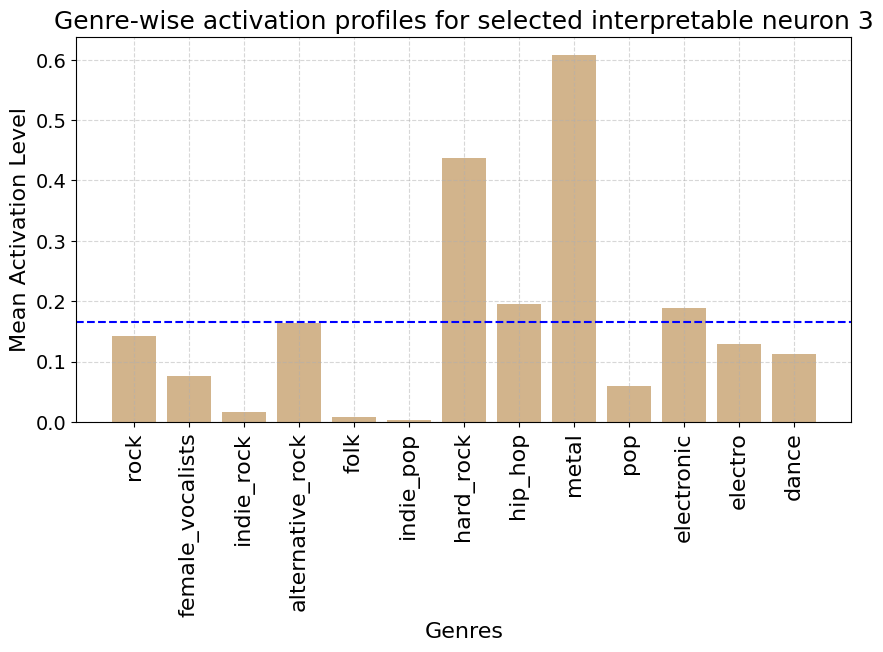

In [509]:
# Metal songs neuron- neuron number 3:

neuron_i = 3
print(f'Top-10 most activating songs for interpretable neuron {neuron_i}:')


fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax1.bar(comparison1.columns, comparison1.iloc[neuron_i,:], color='tan')
ax1.set_title(f'Genre-wise activation profiles for selected interpretable neuron {neuron_i}',fontsize=18)
ax1.set_xlabel('Genres',fontsize=16)
ax1.set_ylabel('Mean Activation Level',fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_xticks(comparison1.columns)
ax1.set_xticklabels(comparison1.columns, rotation=90,fontsize=16)
ax1.tick_params(axis='y', labelsize=14)
ax1.axhline(y=latents_items_df.mean().iloc[neuron_i], color='blue', linestyle='--')


length = 10
neuron_data = highly_activate_movies2neurons.iloc[neuron_i,:]
highly_activate_movies2neurons_table = pd.DataFrame(0, index=range(length), columns=['name','artist', 'genres', 'year'])

for i in highly_activate_movies2neurons_table.index[0:length]:
  highly_activate_movies2neurons_table.iloc[i,0] =  items_data_new_track_id.loc[neuron_data[i]].iloc[0]
  highly_activate_movies2neurons_table.iloc[i,1] =  items_data_new_track_id.loc[neuron_data[i]].iloc[1]
  highly_activate_movies2neurons_table.iloc[i,2] =  items_data_new_track_id.loc[neuron_data[i]].iloc[2]
  highly_activate_movies2neurons_table.iloc[i,3] =  items_data_new_track_id.loc[neuron_data[i]].iloc[3]

highly_activate_movies2neurons_table

Top-10 most activating songs for interpretable neuron 10:


,name,artist,genres,year
0,Don't Cha,The Pussycat Dolls,"pop, female_vocalists, dance, hip_hop, rnb",2014
1,BB Good,Jonas Brothers,"pop, pop_rock",2008
2,Paper Gangsta,Lady Gaga,"electronic, pop, female_vocalists, dance, piano, electro",2012
3,Break It Off,Rihanna,"pop, dance, hip_hop, reggae, rnb",2006
4,Lovebug,Jonas Brothers,"pop, love, 00s, pop_rock",2008
5,Breakin' Dishes,Rihanna,"pop, female_vocalists, dance, hip_hop, rnb, 00s",2008
6,One of the Boys,Katy Perry,"pop, female_vocalists, pop_rock",2008
7,My Paper Heart,The All-American Rejects,"rock, alternative, indie, pop, alternative_rock, punk, punk_rock, emo, love, pop_rock",2002
8,Fag Hag,Lily Allen,"pop, female_vocalists, british, britpop",2009
9,"You Don't Love Me (No, No, No)",Rihanna,"reggae, rnb",2009


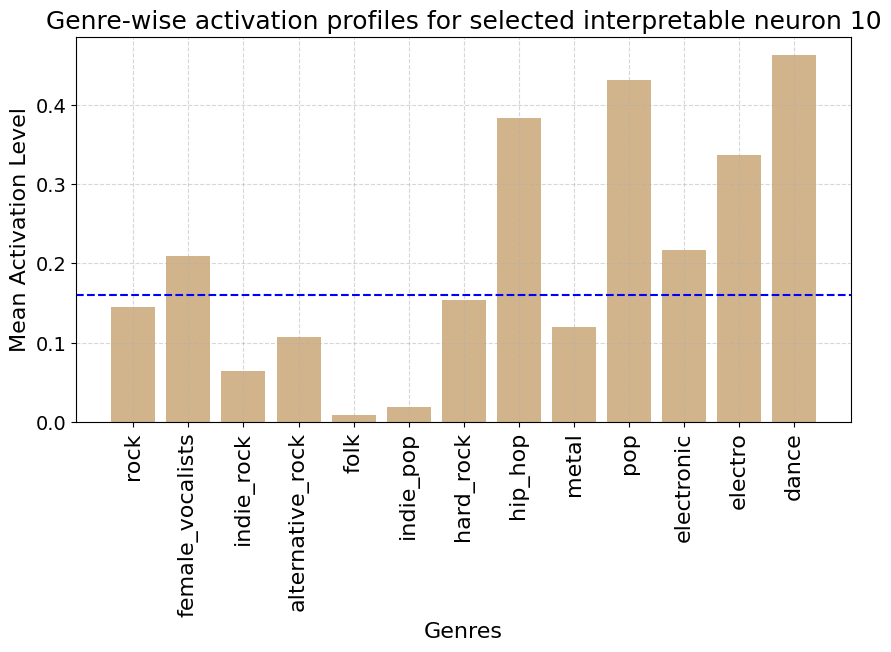

In [508]:
# Mainstream Pop songs neuron- neuron number 10:

neuron_i = 10
print(f'Top-10 most activating songs for interpretable neuron {neuron_i}:')


fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax1.bar(comparison1.columns, comparison1.iloc[neuron_i,:], color='tan')
ax1.set_title(f'Genre-wise activation profiles for selected interpretable neuron {neuron_i}',fontsize=18)
ax1.set_xlabel('Genres',fontsize=16)
ax1.set_ylabel('Mean Activation Level',fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_xticks(comparison1.columns)
ax1.set_xticklabels(comparison1.columns, rotation=90,fontsize=16)
ax1.tick_params(axis='y', labelsize=14)
ax1.axhline(y=latents_items_df.mean().iloc[neuron_i], color='blue', linestyle='--')


length = 12
neuron_data = highly_activate_movies2neurons.iloc[neuron_i,:]
highly_activate_movies2neurons_table = pd.DataFrame(0, index=range(length), columns=['name','artist', 'genres', 'year'])

for i in highly_activate_movies2neurons_table.index[0:length]:
  highly_activate_movies2neurons_table.iloc[i,0] =  items_data_new_track_id.loc[neuron_data[i]].iloc[0]
  highly_activate_movies2neurons_table.iloc[i,1] =  items_data_new_track_id.loc[neuron_data[i]].iloc[1]
  highly_activate_movies2neurons_table.iloc[i,2] =  items_data_new_track_id.loc[neuron_data[i]].iloc[2]
  highly_activate_movies2neurons_table.iloc[i,3] =  items_data_new_track_id.loc[neuron_data[i]].iloc[3]


highly_activate_movies2neurons_table

Top-10 most activating songs for interpretable neuron 1:


,name,artist,genres,year
0,Bowls,Caribou,"electronic, experimental, instrumental, dance, downtempo, idm",2010
1,Jamelia,Caribou,"electronic, ambient, experimental",2010
2,Kaili,Caribou,"electronic, experimental, indie_pop",2010
3,Party With Children,Ratatat,"electronic, instrumental, american, trip_hop, beautiful, chill",2010
4,Leave House,Caribou,"electronic, indie_rock",2010
5,Mahalo,Ratatat,"electronic, instrumental, chillout, american, indie_pop, chill",2010
6,Grape Juice City,Ratatat,"electronic, instrumental, electro, chill",2010
7,Niobe,Caribou,"electronic, psychedelic",2007
8,Computer Face//Pure Being,Flying Lotus,"electronic, experimental, industrial, hip_hop, downtempo, idm",2010
9,Swordfish Hotkiss Night,Empire of the Sun,"electronic, dance, synthpop",2008


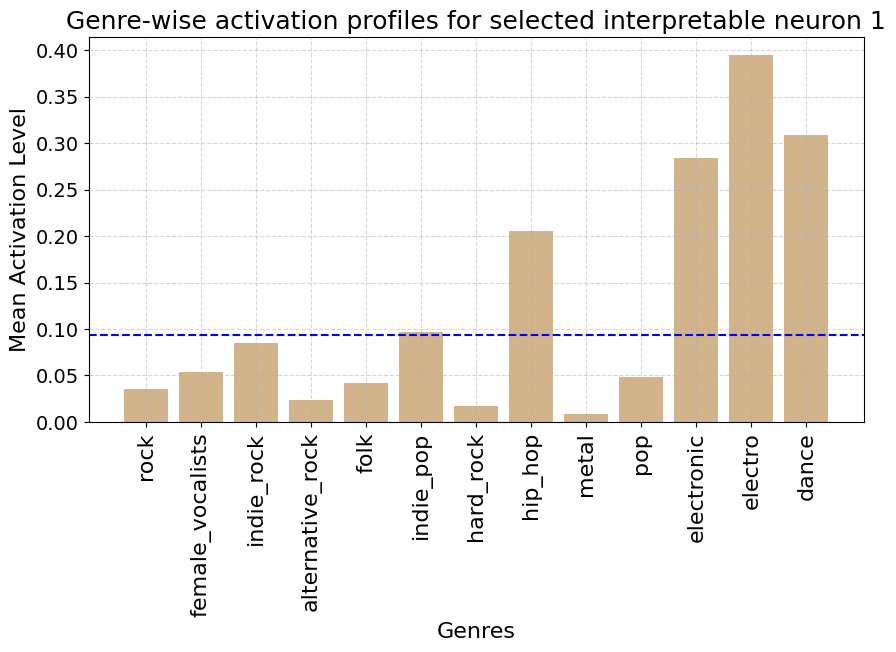

In [478]:
# Electronic songs neuron- neuron number 1:

neuron_i = 1
print(f'Top-10 most activating songs for interpretable neuron {neuron_i}:')

fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax1.bar(comparison1.columns, comparison1.iloc[neuron_i,:], color='tan')
ax1.set_title(f'Genre-wise activation profiles for selected interpretable neuron {neuron_i}',fontsize=18)
ax1.set_xlabel('Genres',fontsize=16)
ax1.set_ylabel('Mean Activation Level',fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_xticks(comparison1.columns)
ax1.set_xticklabels(comparison1.columns, rotation=90,fontsize=16)
ax1.tick_params(axis='y', labelsize=14)
ax1.axhline(y=latents_items_df.mean().iloc[neuron_i], color='blue', linestyle='--')


length = 10
neuron_data = highly_activate_movies2neurons.iloc[neuron_i,:]
highly_activate_movies2neurons_table = pd.DataFrame(0, index=range(length), columns=['name','artist', 'genres', 'year'])

for i in highly_activate_movies2neurons_table.index[0:length]:
  highly_activate_movies2neurons_table.iloc[i,0] =  items_data_new_track_id.loc[neuron_data[i]].iloc[0]
  highly_activate_movies2neurons_table.iloc[i,1] =  items_data_new_track_id.loc[neuron_data[i]].iloc[1]
  highly_activate_movies2neurons_table.iloc[i,2] =  items_data_new_track_id.loc[neuron_data[i]].iloc[2]
  highly_activate_movies2neurons_table.iloc[i,3] =  items_data_new_track_id.loc[neuron_data[i]].iloc[3]

highly_activate_movies2neurons_table

Top-10 most activating songs for interpretable neuron 21:


,name,artist,genres,year
0,I Must Belong Somewhere,Bright Eyes,"indie, folk, singer_songwriter, acoustic, country",2007
1,At the Bottom of Everything,Bright Eyes,"alternative, indie, folk, indie_rock, singer_songwriter, acoustic, emo, love, 00s",2005
2,Hold Time,M. Ward,"indie, folk, singer_songwriter, acoustic, male_vocalists, 00s",2009
3,Gold Mine Gutted,Bright Eyes,"indie, folk, singer_songwriter, emo, beautiful",2005
4,On the Bus Mall,The Decemberists,"indie, folk, acoustic, indie_pop, beautiful, mellow",2005
5,Road to Joy,Bright Eyes,"alternative, indie, folk, indie_rock, singer_songwriter, acoustic, emo, 00s",2005
6,Mount Wroclai (Idle Days),Beirut,"alternative, indie, experimental, folk, singer_songwriter, beautiful",2006
7,Cleanse Song,Bright Eyes,"indie, folk, singer_songwriter, acoustic, indie_pop, emo, love, beautiful, chill",2007
8,"Skin Is, My",Andrew Bird,"indie, folk, singer_songwriter, male_vocalists",2010
9,Here I Dreamt I Was an Architect,The Decemberists,"indie, folk, indie_rock, indie_pop, mellow, chill",2002


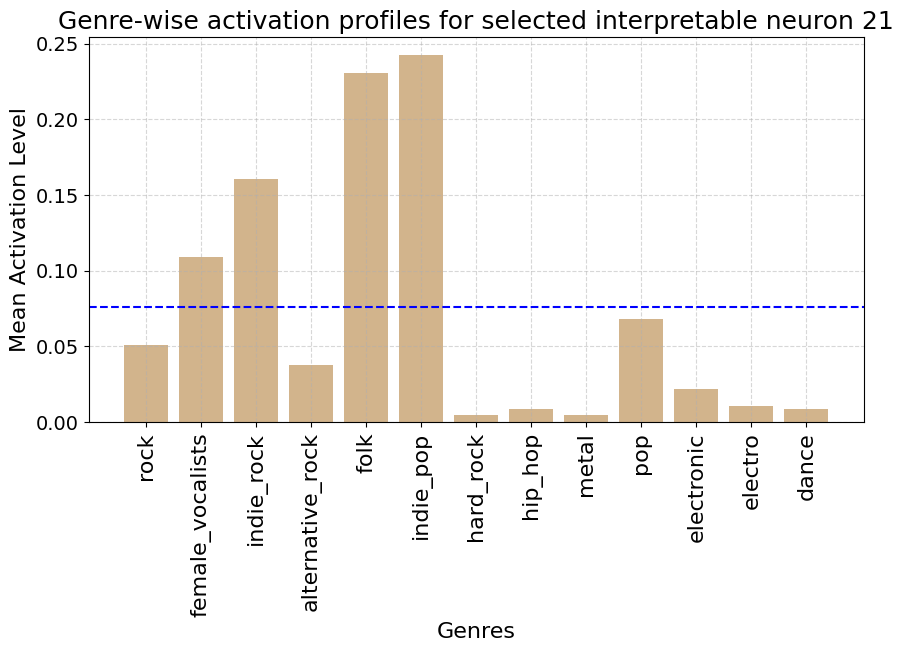

In [500]:
# Folk songs neuron- neuron number 21:

neuron_i = 21
print(f'Top-10 most activating songs for interpretable neuron {neuron_i}:')


fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax1.bar(comparison1.columns, comparison1.iloc[neuron_i,:], color='tan')
ax1.set_title(f'Genre-wise activation profiles for selected interpretable neuron {neuron_i}',fontsize=18)
ax1.set_xlabel('Genres',fontsize=16)
ax1.set_ylabel('Mean Activation Level',fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_xticks(comparison1.columns)
ax1.set_xticklabels(comparison1.columns, rotation=90,fontsize=16)
ax1.tick_params(axis='y', labelsize=14)
ax1.axhline(y=latents_items_df.mean().iloc[neuron_i], color='blue', linestyle='--')


length = 10
neuron_data = highly_activate_movies2neurons.iloc[neuron_i,:]
highly_activate_movies2neurons_table = pd.DataFrame(0, index=range(length), columns=['name','artist', 'genres', 'year'])

for i in highly_activate_movies2neurons_table.index[0:length]:
  highly_activate_movies2neurons_table.iloc[i,0] =  items_data_new_track_id.loc[neuron_data[i]].iloc[0]
  highly_activate_movies2neurons_table.iloc[i,1] =  items_data_new_track_id.loc[neuron_data[i]].iloc[1]
  highly_activate_movies2neurons_table.iloc[i,2] =  items_data_new_track_id.loc[neuron_data[i]].iloc[2]
  highly_activate_movies2neurons_table.iloc[i,3] =  items_data_new_track_id.loc[neuron_data[i]].iloc[3]


highly_activate_movies2neurons_table

Top-10 most activating songs for interpretable neuron 7:


,name,artist,genres,year
0,Orphans,The Gaslight Anthem,"rock, punk_rock, blues, country",2010
1,Beautiful Way,Beck,"rock, alternative, singer_songwriter, 90s, country, male_vocalists, beautiful, mellow, chill",1999
2,House Of Broken Love,Great White,"hard_rock, blues_rock",1989
3,Rhyme & Reason,Dave Matthews Band,"rock, acoustic",1994
4,Meet Me By The River's Edge,The Gaslight Anthem,"rock, punk, punk_rock, american, 00s",2008
5,505,Arctic Monkeys,"rock, alternative, indie, alternative_rock, indie_rock, british, beautiful",2007
6,The '59 Sound,The Gaslight Anthem,"rock, alternative, punk_rock, american, 00s",2018
7,The Backseat,The Gaslight Anthem,"rock, punk, indie_rock, punk_rock, american, 00s",2008
8,Even Cowgirls Get The Blues,The Gaslight Anthem,"rock, punk_rock",2008
9,Old White Lincoln,The Gaslight Anthem,"rock, punk, indie_rock, punk_rock, american, love, 00s",2008


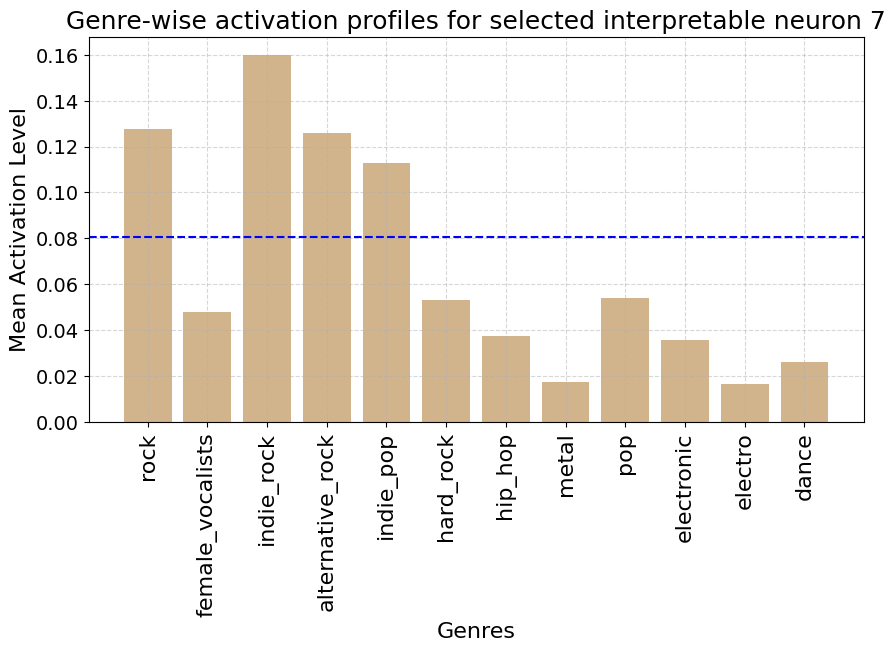

In [514]:
# Rock songs neuron- neuron number 7:

neuron_i = 7
print(f'Top-10 most activating songs for interpretable neuron {neuron_i}:')

fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax1.bar(comparison1.columns, comparison1.iloc[neuron_i,:], color='tan')
ax1.set_title(f'Genre-wise activation profiles for selected interpretable neuron {neuron_i}',fontsize=18)
ax1.set_xlabel('Genres',fontsize=16)
ax1.set_ylabel('Mean Activation Level',fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_xticks(comparison1.columns)
ax1.set_xticklabels(comparison1.columns, rotation=90,fontsize=16)
ax1.tick_params(axis='y', labelsize=14)
ax1.axhline(y=latents_items_df.mean().iloc[neuron_i], color='blue', linestyle='--')


length = 10
neuron_data = highly_activate_movies2neurons.iloc[neuron_i,:]
highly_activate_movies2neurons_table = pd.DataFrame(0, index=range(length), columns=['name','artist', 'genres', 'year'])

for i in highly_activate_movies2neurons_table.index[0:length]:
  highly_activate_movies2neurons_table.iloc[i,0] =  items_data_new_track_id.loc[neuron_data[i]].iloc[0]
  highly_activate_movies2neurons_table.iloc[i,1] =  items_data_new_track_id.loc[neuron_data[i]].iloc[1]
  highly_activate_movies2neurons_table.iloc[i,2] =  items_data_new_track_id.loc[neuron_data[i]].iloc[2]
  highly_activate_movies2neurons_table.iloc[i,3] =  items_data_new_track_id.loc[neuron_data[i]].iloc[3]


highly_activate_movies2neurons_table

In [515]:
neuron_i = 20
print(f'Top-10 most activating songs for \'popular songs\' neuron- {neuron_i}:')

length = 10
neuron_data = highly_activate_movies2neurons.iloc[neuron_i,:]
highly_activate_movies2neurons_table = pd.DataFrame(0, index=range(length), columns=['name','artist', 'popularity percentage'])

for i in highly_activate_movies2neurons_table.index[0:length]:
  highly_activate_movies2neurons_table.iloc[i,0] =  items_data_new_track_id.loc[neuron_data[i]].iloc[0]
  highly_activate_movies2neurons_table.iloc[i,1] =  items_data_new_track_id.loc[neuron_data[i]].iloc[1]
  highly_activate_movies2neurons_table.iloc[i,2] =  round(np.where(num_users_per_movie_sort.index == neuron_data[i])[0][0]/ITEMS, 3)*100

highly_activate_movies2neurons_table

Top-10 most activating songs for 'popular songs' neuron- 20:


,name,artist,popularity percentage
0,Someone Is Waiting,Neutral Milk Hotel,11.1
1,Nothing Better,The Postal Service,0.3
2,MIA,Chevelle,0.0
3,This Place Is a Prison,The Postal Service,1.9
4,Such Great Heights,The Postal Service,0.0
5,Daniel Cowman,Regina Spektor,10.0
6,You've Passed,Neutral Milk Hotel,10.6
7,Gardenhead / Leave Me Alone,Neutral Milk Hotel,0.9
8,Seal Jubilee,Bat for Lashes,3.4
9,A Sisters Social Agony,Camera Obscura,11.4


In [216]:
# Set the maximum column width
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)